# Initialize

In [1]:
import os
import glob
import feather
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import anndata
import numpy as np
import copy
import openpyxl
import seaborn as sns
import nbimporter
import FFPE_helpers as ffpe
from harmony import harmonize

sns.set(font_scale=1.5)
sns.set_style("white")

sc.settings.figdir = 'FFPE/analysis/mouse_brain'
sc.set_figure_params(figsize=(6,5), dpi=100, frameon=False)
!mkdir -p sc.settings.figdir

# make cluster palette
ania_palette = ['#CAE8F6',
                '#006E82', 
                '#005AC8', 
                '#bcbcbc', 
                '#F0F032',
                '#14D2DC',
                '#AA0A3C',
                '#FA2800', 
                '#FA7850', 
                '#FA5078', 
                '#96B400',
                '#0AB45A',
                '#FA78FA',
                '#A0FA82',
                '#FAE6BE',
                '#c8befa',
                '#E69F00',
                '#8214A0',
                '#f6d48f',
                '#00A0FA',
                '#82A0BE'
               ]

# SS2 data of mouse cortex FFPE with xylene RT

FFPE_helpers.ipynb:73: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  "            \n",
/home/jupyter/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


                      Sample        i7     i7_rc     i5_rc  num_nuclei  \
sample                                                                   
FFPE_MB9_R_01  FFPE_MB9_R_01  TCGCCTTA  TAAGGCGA  ATAGAGAG           1   

                plate brain seq_type sample_batch  n_counts  n_genes  
sample                                                                
FFPE_MB9_R_01  plate9     R      ss2         1202  522948.0     1432  
(380, 36006)
Adding library type
20201202_AM_SS2 (380, 36006)
(380, 13352)
(380, 22654)
Returned ad_hg19, ad_mm10, ad_all


FFPE_helpers.ipynb:73: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  "            \n",
/home/jupyter/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


                  i7_rc     i5_rc  num_nuclei plate brain library_type  \
sample                                                                   
brain_MB18_A2  GGAGCTAC  ATAGAGAG           1  MB18     L         FFPE   

              seq_type sample_batch  n_counts  n_genes  
sample                                                  
brain_MB18_A2      ss2         0216  234230.0     1950  
(374, 43728)
20210216_AM_SS2_mouse_brain (374, 43728)
(374, 21131)
(374, 22597)
Returned ad_hg19, ad_mm10, ad_all


FFPE_helpers.ipynb:73: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  "            \n",
/home/jupyter/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1830: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


                  i7_rc     i5_rc  num_nuclei plate brain library_type  \
sample                                                                   
brain_MB16_A1  ACTCGCTA  ATAGAGAG           1  MB16     L         FFPE   

              seq_type sample_batch  n_counts  n_genes  
sample                                                  
brain_MB16_A1      ss2         0314   16689.0      726  
(377, 41852)
20210314_AM_SS2_mouse_brain_with_frozen (377, 41852)
(377, 18557)
(377, 23295)
Returned ad_hg19, ad_mm10, ad_all


/home/jupyter/.local/lib/python3.7/site-packages/anndata/_core/anndata.py:1785: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  [AnnData(sparse.csr_matrix(a.shape), obs=a.obs) for a in all_adatas],


(1131, 24191)


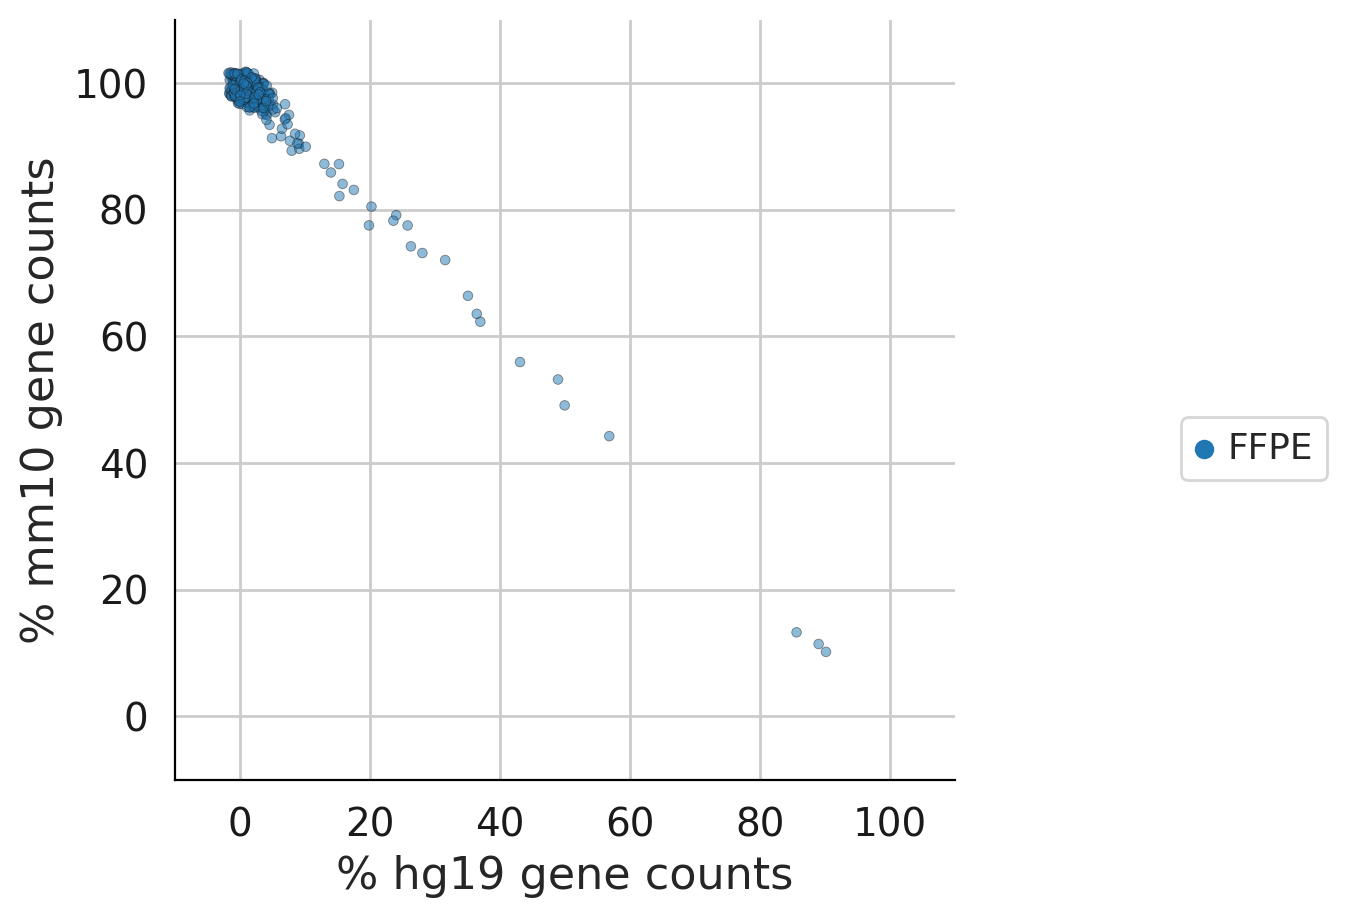

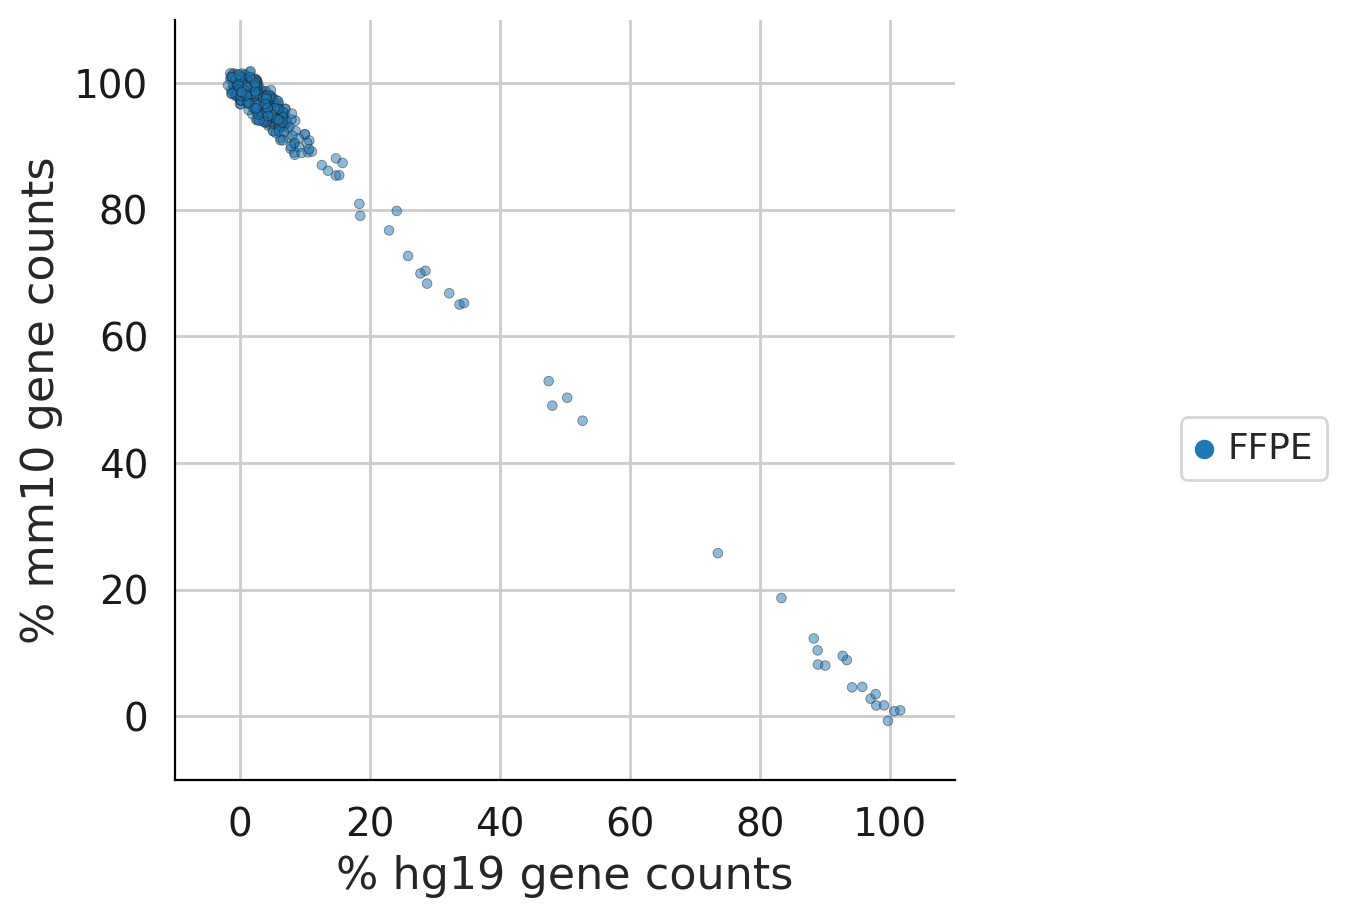

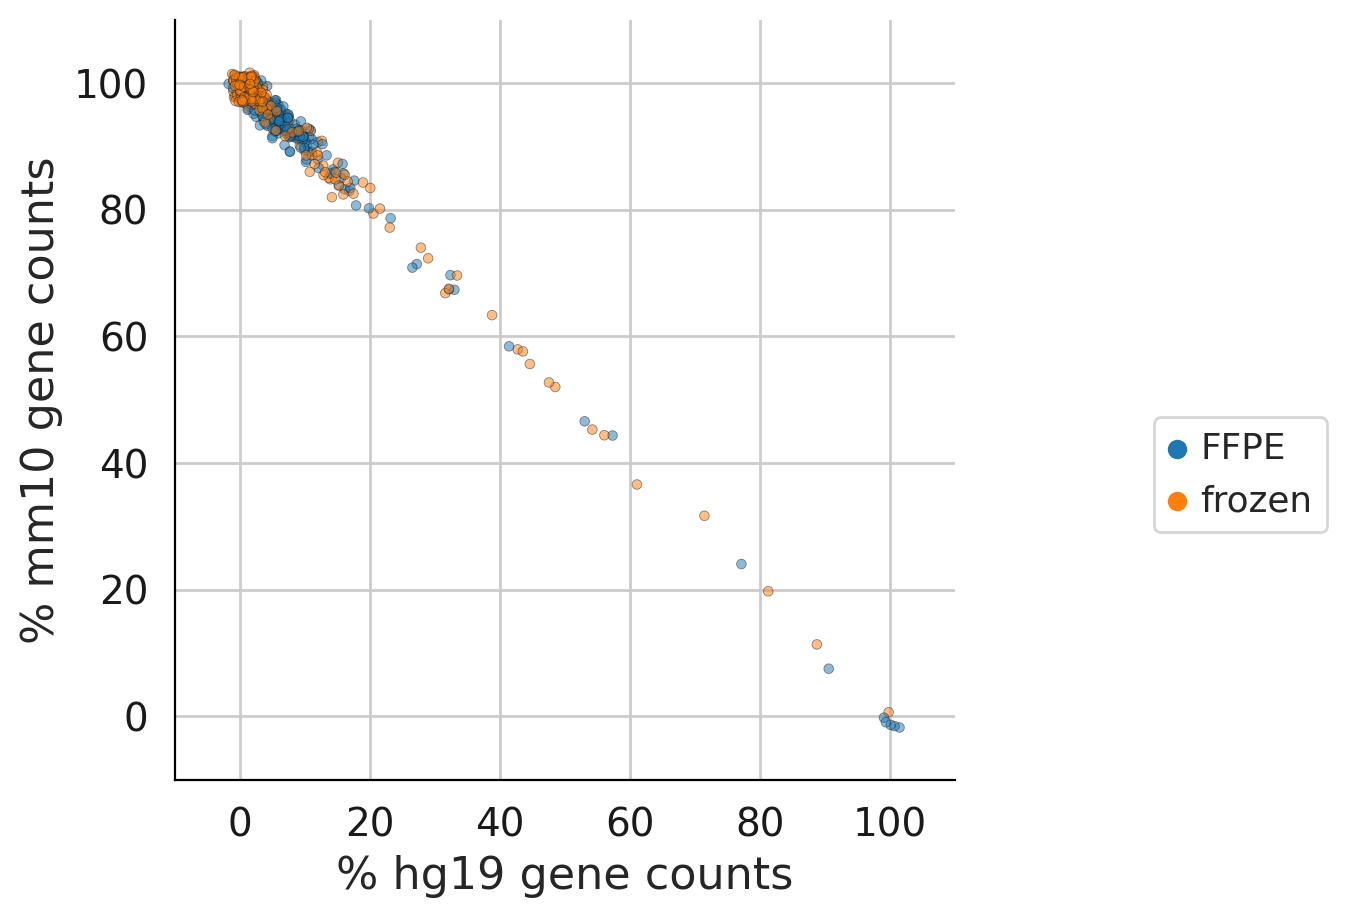

In [2]:
ss2_folders = ['20201202_AM_SS2', '20210216_AM_SS2_mouse_brain', '20210314_AM_SS2_mouse_brain_with_frozen']
suffix = ['1202', '0216', '0314']
refgenomes = ['hg19_mm10', 'hg19_mm10', 'hg19_mm10']

adatas_ss2 = []
for run_fold, run_suff, ref in zip(ss2_folders, suffix, refgenomes):
    ad = ffpe.import_feather(run_fold,"ss2",run_suff)
    ad.obs['mouse_brain_hemisphere'] = ad.obs['brain']
    
    if run_suff=='1202': 
        print('Adding library type')
        ad.obs['library_type'] = 'FFPE'
        
    print(run_fold, ad.shape)
    
    if ref == 'hg19_mm10':
        ad_hg19, ad_mm10, ad_all = ffpe.split_hg19_and_mm10(ad)
        ffpe.scatter_hg19_vs_mm10(ad_all, hue_var='library_type')
        ad_mm10.var_names_make_unique()
        
        adatas_ss2.append(ad_mm10)
    else: 
        ad.obs['n_counts_mm10'] = ad.obs['n_counts']
        ad.obs['n_genes_mm10'] = ad.obs['n_genes']
        ad.obs['percent_mm10'] = 100
        ad.obs['percent_hg19'] = 0
        ad.var_names_make_unique()
        adatas_ss2.append(ad)
        
ad_ss2 = adatas_ss2[0].concatenate(adatas_ss2[1:],join='outer')
ad_ss2.var_names_make_unique()

print(ad_ss2.shape)

### save raw data

In [3]:
ad_bulk = ad_ss2[ad_ss2.obs['num_nuclei']>0]
ad_single = ad_ss2[ad_ss2.obs['num_nuclei']==1]
ad_zero = ad_ss2[ad_ss2.obs['num_nuclei']==0]

In [4]:
ad_single = ad_single[ad_single.obs['library_type']=='FFPE',:].copy()
print(ad_single.shape)

(905, 24191)


In [5]:
# save
ad_single.write('FFPE/analysis/mouse_brain/SS2_mouse_cortex_raw_v2.h5ad')

## QC

In [2]:
# save
ad_single = sc.read('FFPE/analysis/mouse_brain/SS2_mouse_cortex_raw_v2.h5ad')

Remove bad plates

In [3]:
ad_single = ad_single[~ad_single.obs['plate'].isin(['MB19','MB20','plate22']),:].copy()
ad_single.shape

(630, 24191)

In [4]:
# rename plate names
plate_dict = {'MB14':'Plate1',
             'MB16':'Plate2',
             'MB17':'Plate3',
             'MB18':'Plate4',
             'plate9':'Plate5',
             'plate10':'Plate6',
             'plate21':'Plate7'}
ad_single.obs['Plate'] = ad_single.obs['plate'].map(plate_dict)

In [5]:
# fill NaNs, remove unobserved genes

ad_single.X[np.isnan(ad_single.X)] = 0

# remove unobserved genes
ad_single.var['total_counts'] = ad_single.X.sum(axis=0)
# remove unobserved genes
print(ad_single.shape)
ad_single = ad_single[:,ad_single.var['total_counts']>0]
print(sum(ad_single.X.sum(axis=0)>0))

# calculate mitochondrial content
ffpe.calc_mito_ncounts(ad_single, case='mouse')

(630, 24191)
21608


FFPE_helpers.ipynb:10: RuntimeWarning: invalid value encountered in true_divide
  "import glob\n",
FFPE_helpers.ipynb:10: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  "import glob\n",


AnnData object with n_obs × n_vars = 630 × 21608
    obs: 'Sample', 'i7', 'i7_rc', 'i5_rc', 'num_nuclei', 'plate', 'brain', 'seq_type', 'sample_batch', 'n_counts', 'n_genes', 'mouse_brain_hemisphere', 'library_type', 'n_counts_mm10', 'n_genes_mm10', 'percent_mm10', 'percent_hg19', 'batch', 'Plate', 'frac_mito'
    var: 'total_counts'

In [6]:
ad_single.obs['sample_type'] = 'FFPE_SS2'
ad_single.obs['library_type'] = 'FFPE_SS2'

## plot all QC metrics before filtering

Mapping 

557


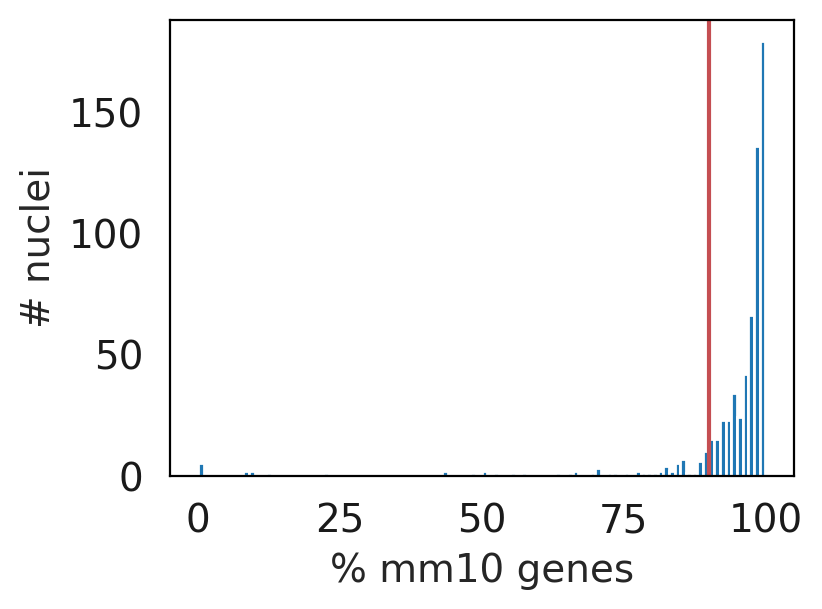

In [9]:
PERC_MM10 = 90
COND_MM10 = ad_single.obs['percent_mm10']>=PERC_MM10

plt.figure(figsize=(4,3))
x = plt.hist(ad_single.obs['percent_mm10'], bins=100)
print(sum(COND_MM10))
plt.axvline(PERC_MM10, color='r')
plt.xlabel('% mm10 genes')
plt.ylabel('# nuclei')
plt.grid(None)
plt.savefig('%s/PREFILTER_hist_perc_mm10.pdf' %(sc.settings.figdir), bbox_inches='tight')

Mitochondrial content

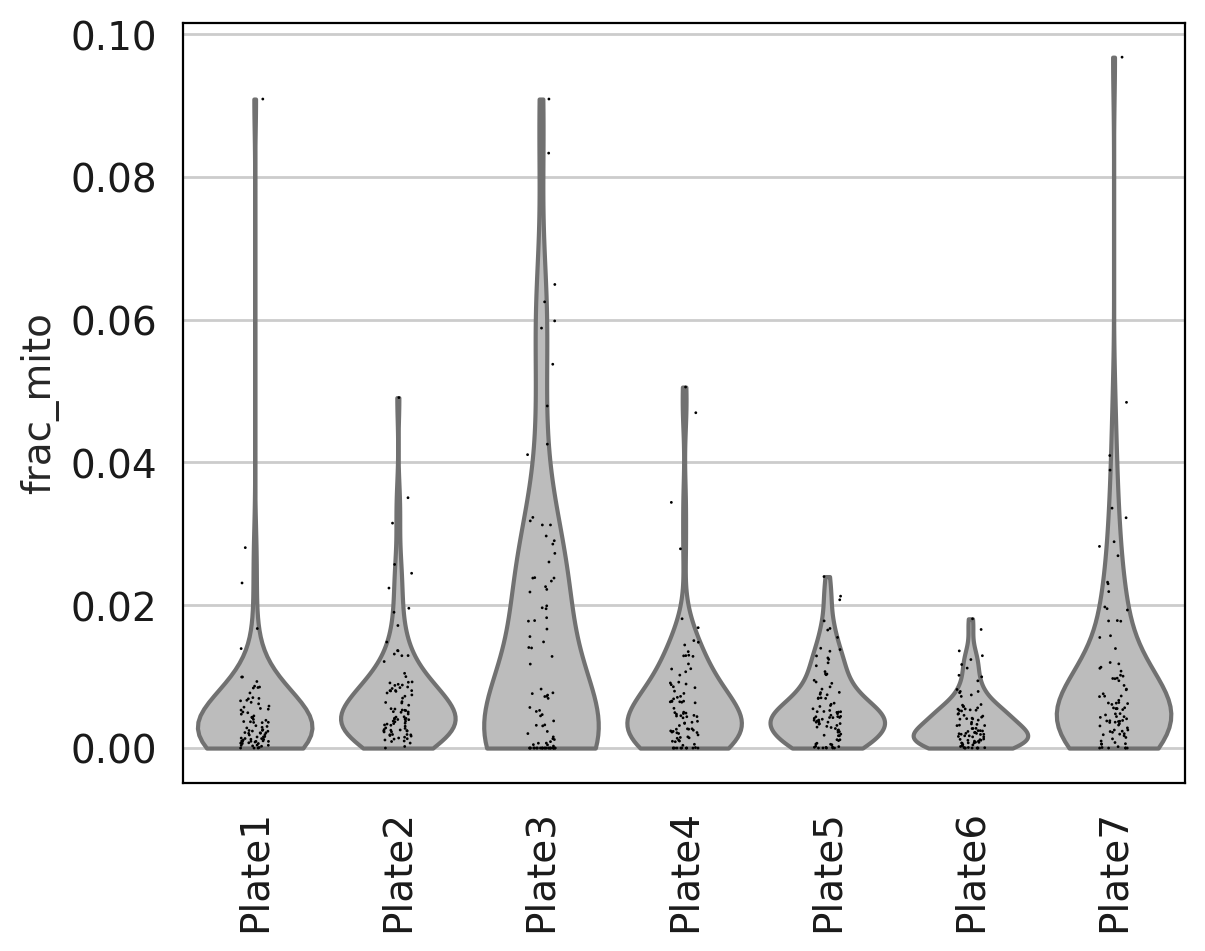

615
630


In [10]:
MITO_THRESH = 0.05
COND_MITO = ad_single.obs['frac_mito']<MITO_THRESH

sc.pl.violin(ad_single, keys=['frac_mito'], groupby='Plate', rotation=90,
             palette=['#bcbcbc'], save='_PREFILTER_SS2_frac_mito_by_Plate_renamed')

print(sum(COND_MITO))
print(ad_single.shape[0])

Genes 

530


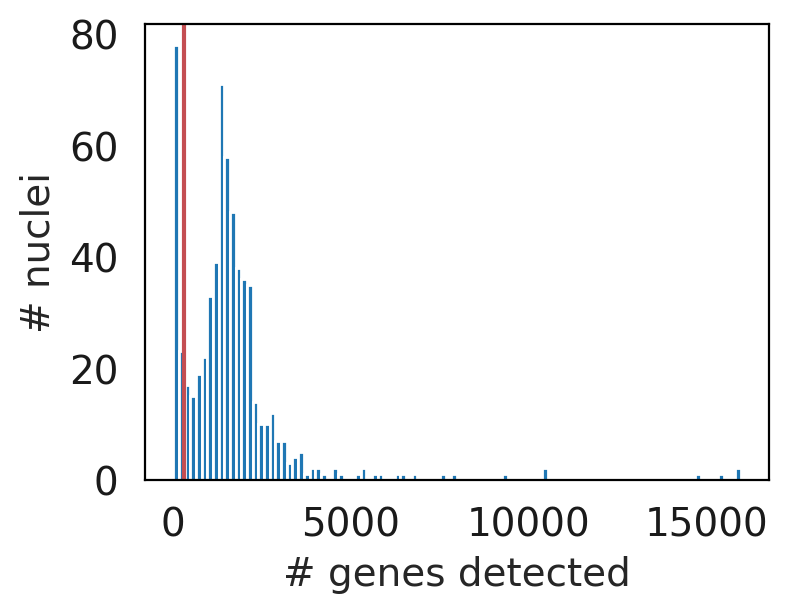

In [11]:
MIN_GENES = 300

COND_GENES = (ad_single.obs['n_genes_mm10']>=MIN_GENES)

print(sum(COND_GENES))

plt.figure(figsize=(4,3))

x = plt.hist(ad_single.obs['n_genes_mm10'], bins=100)

plt.axvline(MIN_GENES, color='r')
plt.xlabel('# genes detected')
plt.ylabel('# nuclei')
plt.grid(None)
plt.savefig('%s/PREFILTER_hist_ngenes_detected.pdf' %(sc.settings.figdir), bbox_inches='tight')

Doublets

565


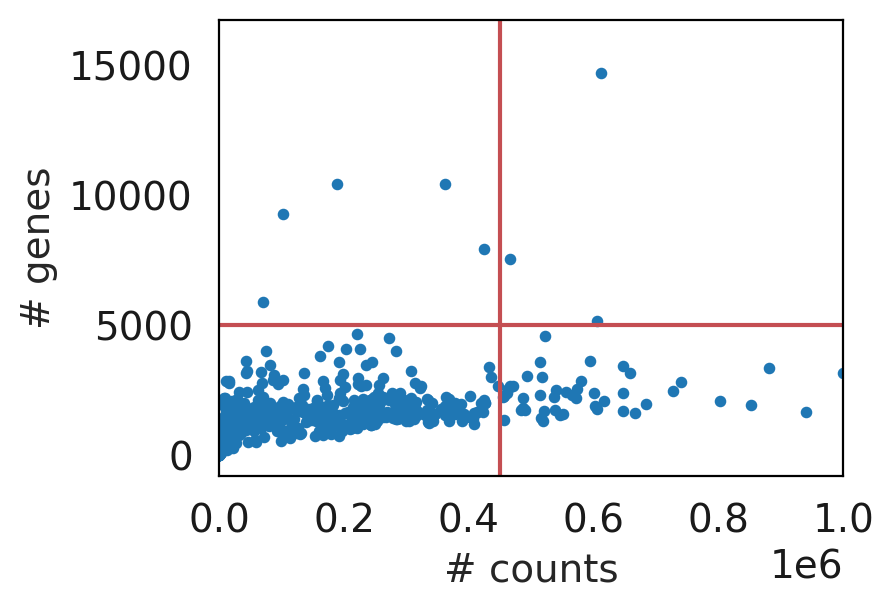

In [14]:
MAX_COUNTS = 450000
MAX_GENES = 5000

COND_DOUBLETS = (ad_single.obs['n_counts_mm10']<=MAX_COUNTS) & (ad_single.obs['n_genes_mm10']<=MAX_GENES)

plt.figure(figsize=(4,3))
plt.scatter(data=ad_single.obs, x='n_counts_mm10', y='n_genes_mm10', s=10)
plt.axvline(MAX_COUNTS, color='r')
plt.axhline(MAX_GENES, color='r')
plt.xlim([0,1000000])
plt.xlabel('# counts')
plt.ylabel('# genes')
plt.grid(None)

print(sum(COND_DOUBLETS))
plt.savefig('%s/PREFILTER_scatter_ncounts_ngenes_prefilter.pdf' %(sc.settings.figdir), bbox_inches='tight')

In [15]:
ad_single.shape

(630, 21608)

## Do the actual filtering

In [16]:
sum(COND_MM10 & COND_MITO & COND_GENES & COND_DOUBLETS)

427

In [16]:
ad_single = ad_single[(COND_MM10 & COND_MITO & COND_GENES & COND_DOUBLETS),:].copy()

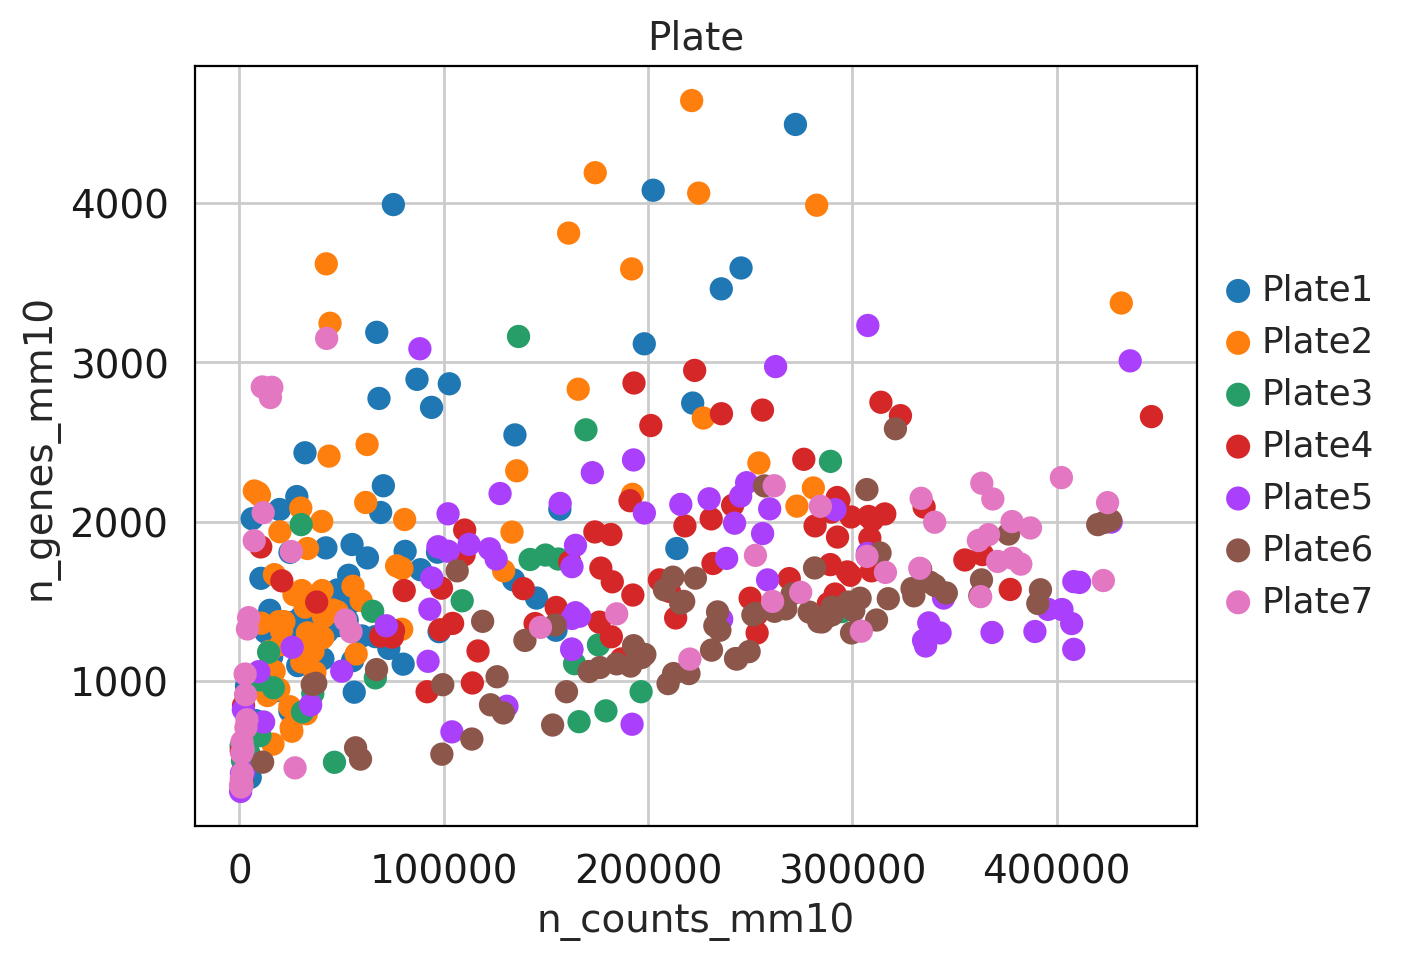

In [17]:
sc.pl.scatter(ad_single, x='n_counts_mm10', 
              y='n_genes_mm10', color='Plate',
              save='_SS2_genes_vs_counts_post_filter')

## Plot post-filter QC metrics

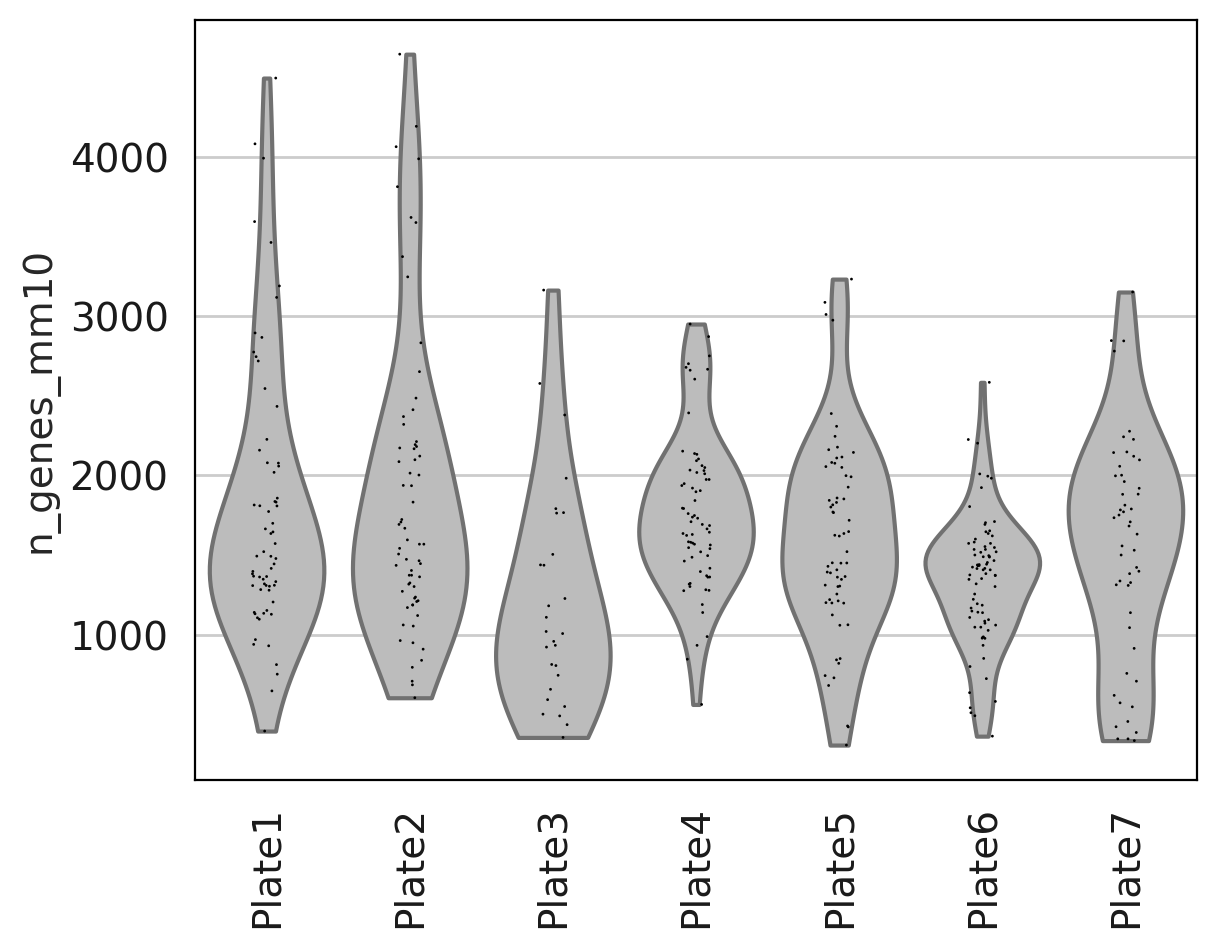

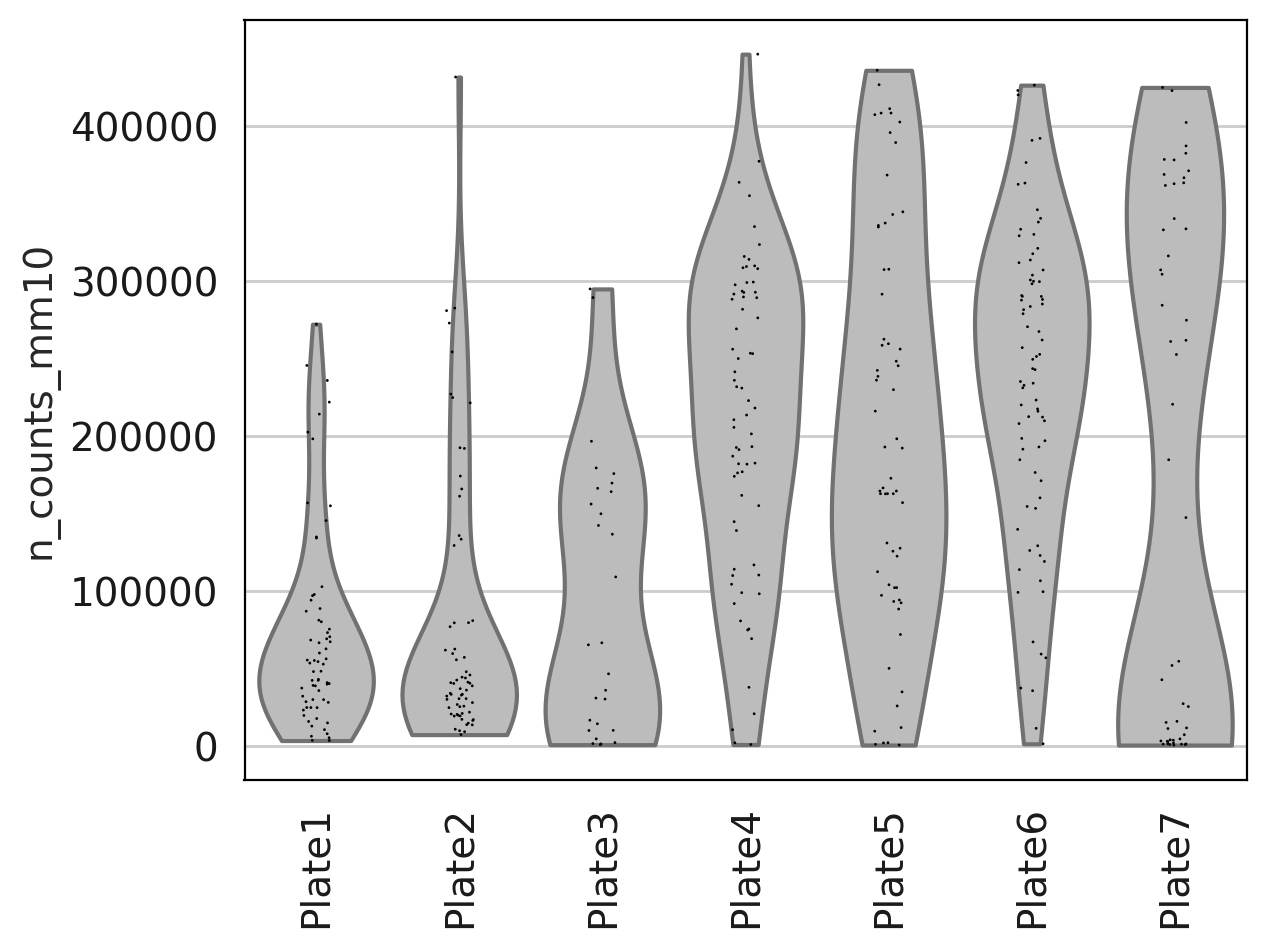

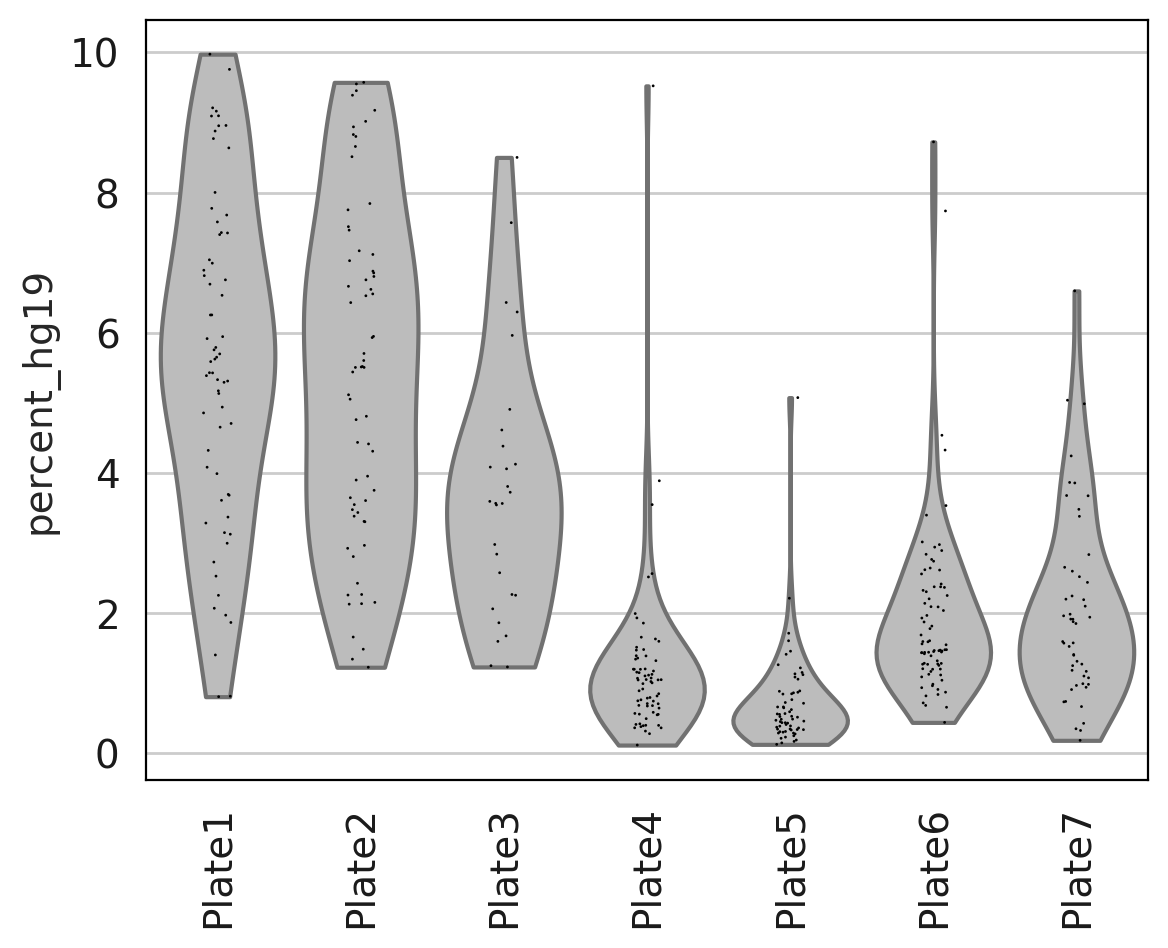

In [18]:
sc.pl.violin(ad_single, keys=['n_genes_mm10'], groupby='Plate', rotation=90, 
             palette=['#bcbcbc'], save='_SS2_genes_by_plate')
sc.pl.violin(ad_single, keys=['n_counts_mm10'], groupby='Plate', rotation=90, 
             palette=['#bcbcbc'], save='_SS2_by_plate')
sc.pl.violin(ad_single, keys=['percent_hg19'], groupby='Plate', rotation=90, 
             palette=['#bcbcbc'], save='_perc_hg19_by_plate')

### save filtered data

In [19]:
# save
ad_single.write('FFPE/analysis/mouse_brain/SS2_mouse_cortex_filtered_v2.h5ad')

### load filtered data

In [ ]:
# load raw
ad_single = sc.read('FFPE/analysis/mouse_brain/SS2_mouse_cortex_filtered_v2.h5ad')

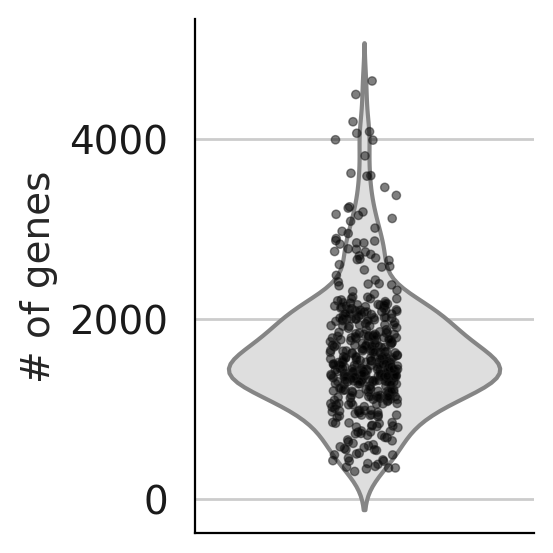

In [20]:
fig, ax = plt.subplots(figsize=(3,3))
sns.set(font_scale=1.2)
sns.set_style("white")
g = sns.stripplot(y='n_genes_mm10',
                  data=ad_single.obs, 
                    jitter=True,
                    marker='o',
                    palette=['#000000'],
                    size=3,
                    alpha=0.5,
                    edgecolor='k',
                    linewidth=0.5,
                    )
g = sns.violinplot(y='n_genes_mm10',
                  data=ad_single.obs, 
                   inner=None,
                   color='#DEDEDE')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.yticks(np.arange(0,5000,2000))
plt.xticks(rotation=90)
ax.set_ylabel('# of genes')
# g.legend(loc='upper right', ncol=1, bbox_to_anchor=(1.45,0.5))
# g.legend_.remove()
plt.tight_layout()
g.get_figure().savefig(bbox_inches='tight',
                       fname='%s/SS2_single_nuclei_ngenes_v2.pdf' %(sc.settings.figdir))

## normalize by gene lengths

In [ ]:
!gsutil cp gs://fc-7efdd0d1-eab4-4296-8132-35134e707b6b/pyannotables.pickle .

In [21]:
mouse_lens = ffpe.load_gene_len_dict('mouse')

In [22]:
mouse_lens = mouse_lens.reindex(ad_single.var.index).dropna()
mouse_lens

Length
gene_name            
0610009B22Rik   998.0
0610009L18Rik   619.0
0610010F05Rik  5226.0
0610012G03Rik  1445.0
0610025J13Rik  1121.0
...               ...
mt-Nd2         1038.0
mt-Nd3          348.0
mt-Nd4l         297.0
mt-Nd5         1824.0
mt-Nd6          519.0

[20347 rows x 1 columns]

In [23]:
print(ad_single.shape)
print(ad_single[:, mouse_lens.index].shape)

(427, 21608)
(427, 20347)


In [24]:
# keep genes with known lengths from pyannotables
ad_single = ad_single[:,mouse_lens.index]

In [25]:
np.log(mouse_lens['Length'].values)

array([6.90575328, 6.42810527, 8.56140145, ..., 5.69373214, 7.50878717,
       6.25190388])

In [26]:
assert (ad_single.var.index == mouse_lens.index).sum() == ad_single.shape[1]

ad_norm = ad_single.copy()
log_lengths = np.log(mouse_lens['Length'].values)
ad_norm.X = ad_norm.X / (log_lengths)

# round to integer
ad_norm.X = np.rint(ad_norm.X)

In [27]:
ad_single = ad_norm

### save len normalized

In [28]:
ad_norm.write('FFPE/analysis/mouse_brain/SS2_mouse_cortex_filtered_len_norm_v2.h5ad')

## Unsupervised clustering

In [ ]:
ad_single = sc.read('FFPE/analysis/mouse_brain/SS2_mouse_cortex_filtered_len_norm_v2.h5ad')

In [29]:
ad = ad_single.copy()
print(ad.shape)
ad.layers['raw'] = ad.X.copy()
sc.pp.normalize_per_cell(ad)
sc.pp.log1p(ad)

(427, 20347)


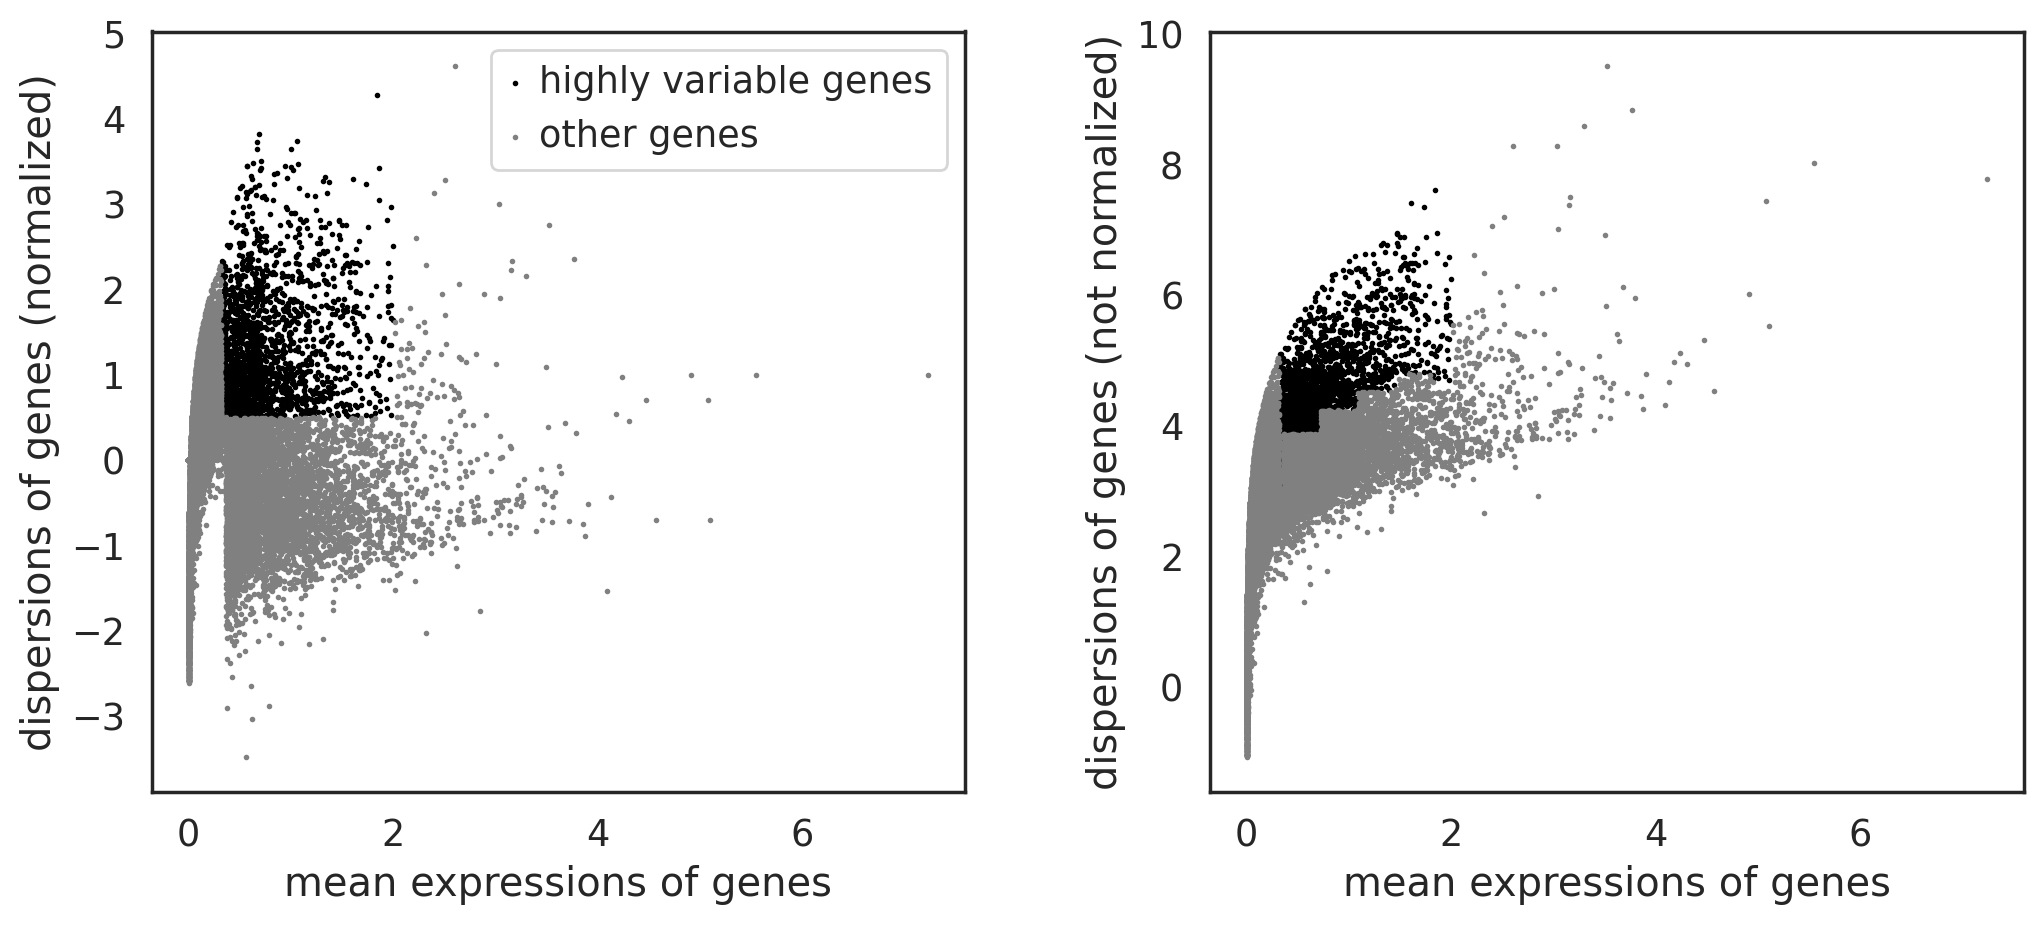

2059 highly variable genes of 20347 total


In [30]:
sc.pp.highly_variable_genes(ad, min_mean=0.32, max_mean=2, min_disp=0.5)
sc.pl.highly_variable_genes(ad)
print('%i highly variable genes of %i total' %(sum(ad.var['highly_variable']), ad.shape[1]))

In [31]:
sc.pp.regress_out(ad, ['n_counts_mm10'])
sc.pp.regress_out(ad, ['Plate'])
sc.pp.scale(ad, max_value=10)
ad.layers['scaled'] = ad.X.copy()

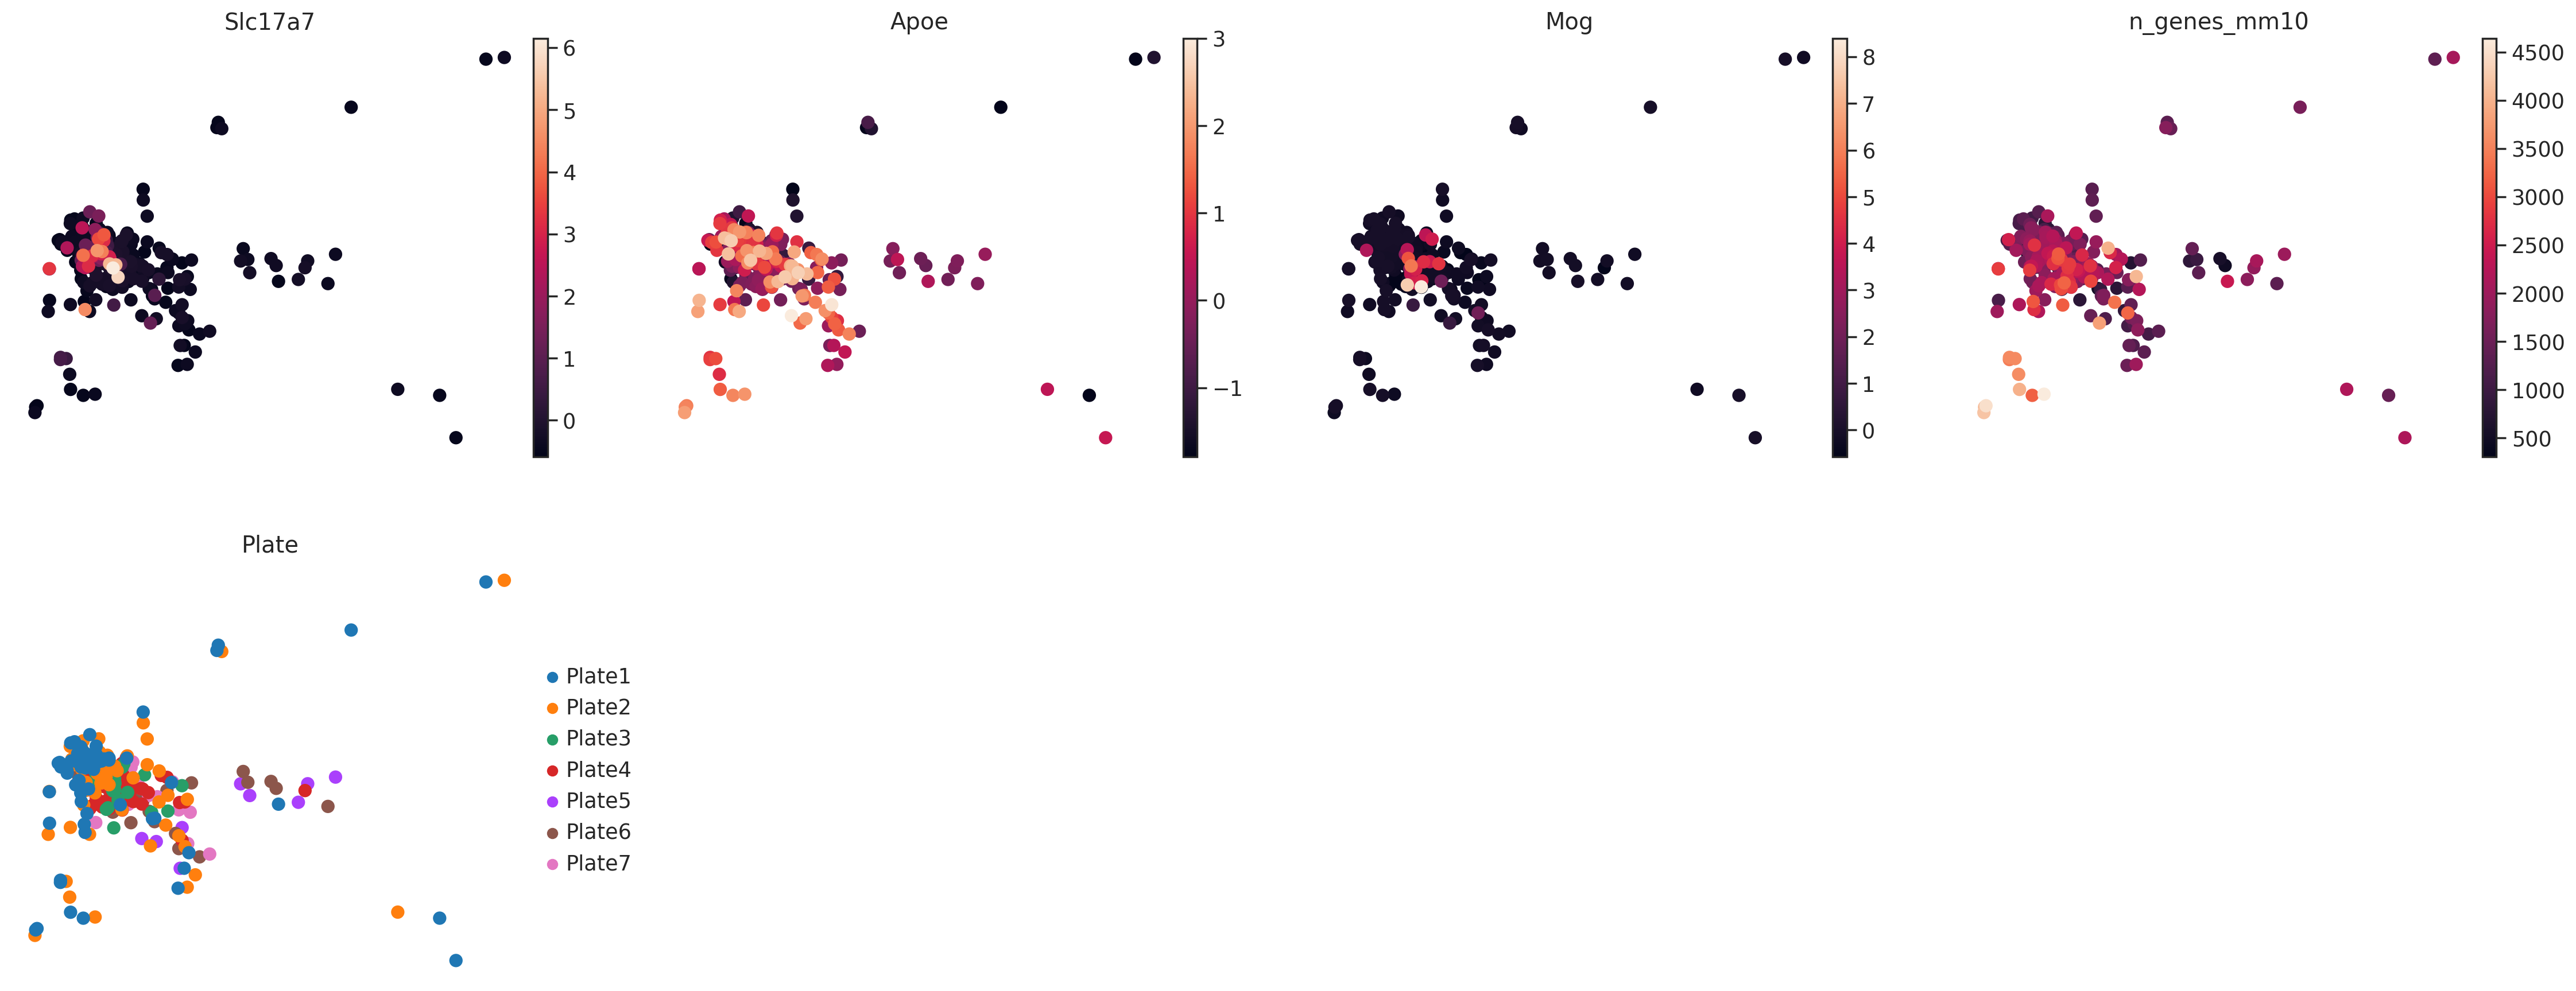

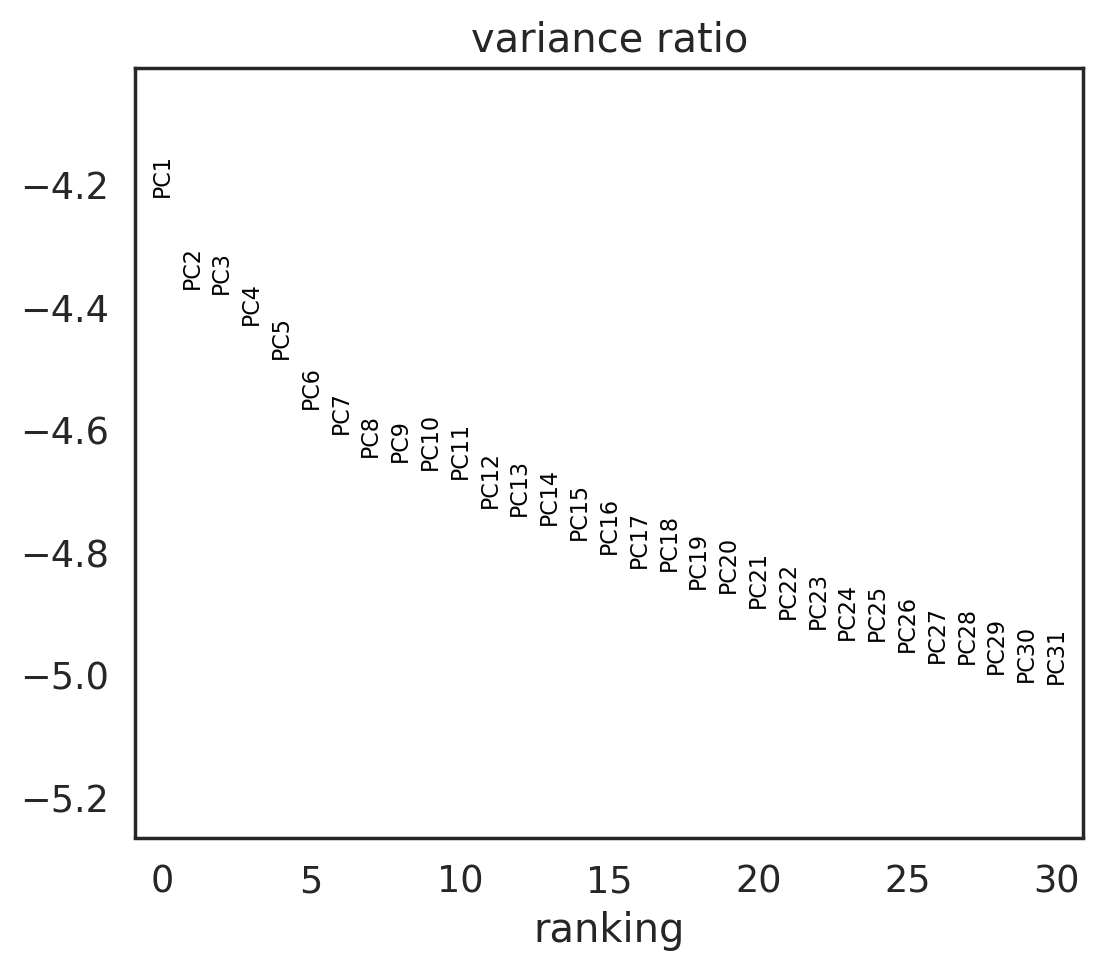

In [32]:
sc.tl.pca(ad, svd_solver='arpack')
sc.pl.pca(ad, color=['Slc17a7','Apoe','Mog','n_genes_mm10', 'Plate'])
sc.pl.pca_variance_ratio(ad, log=True)

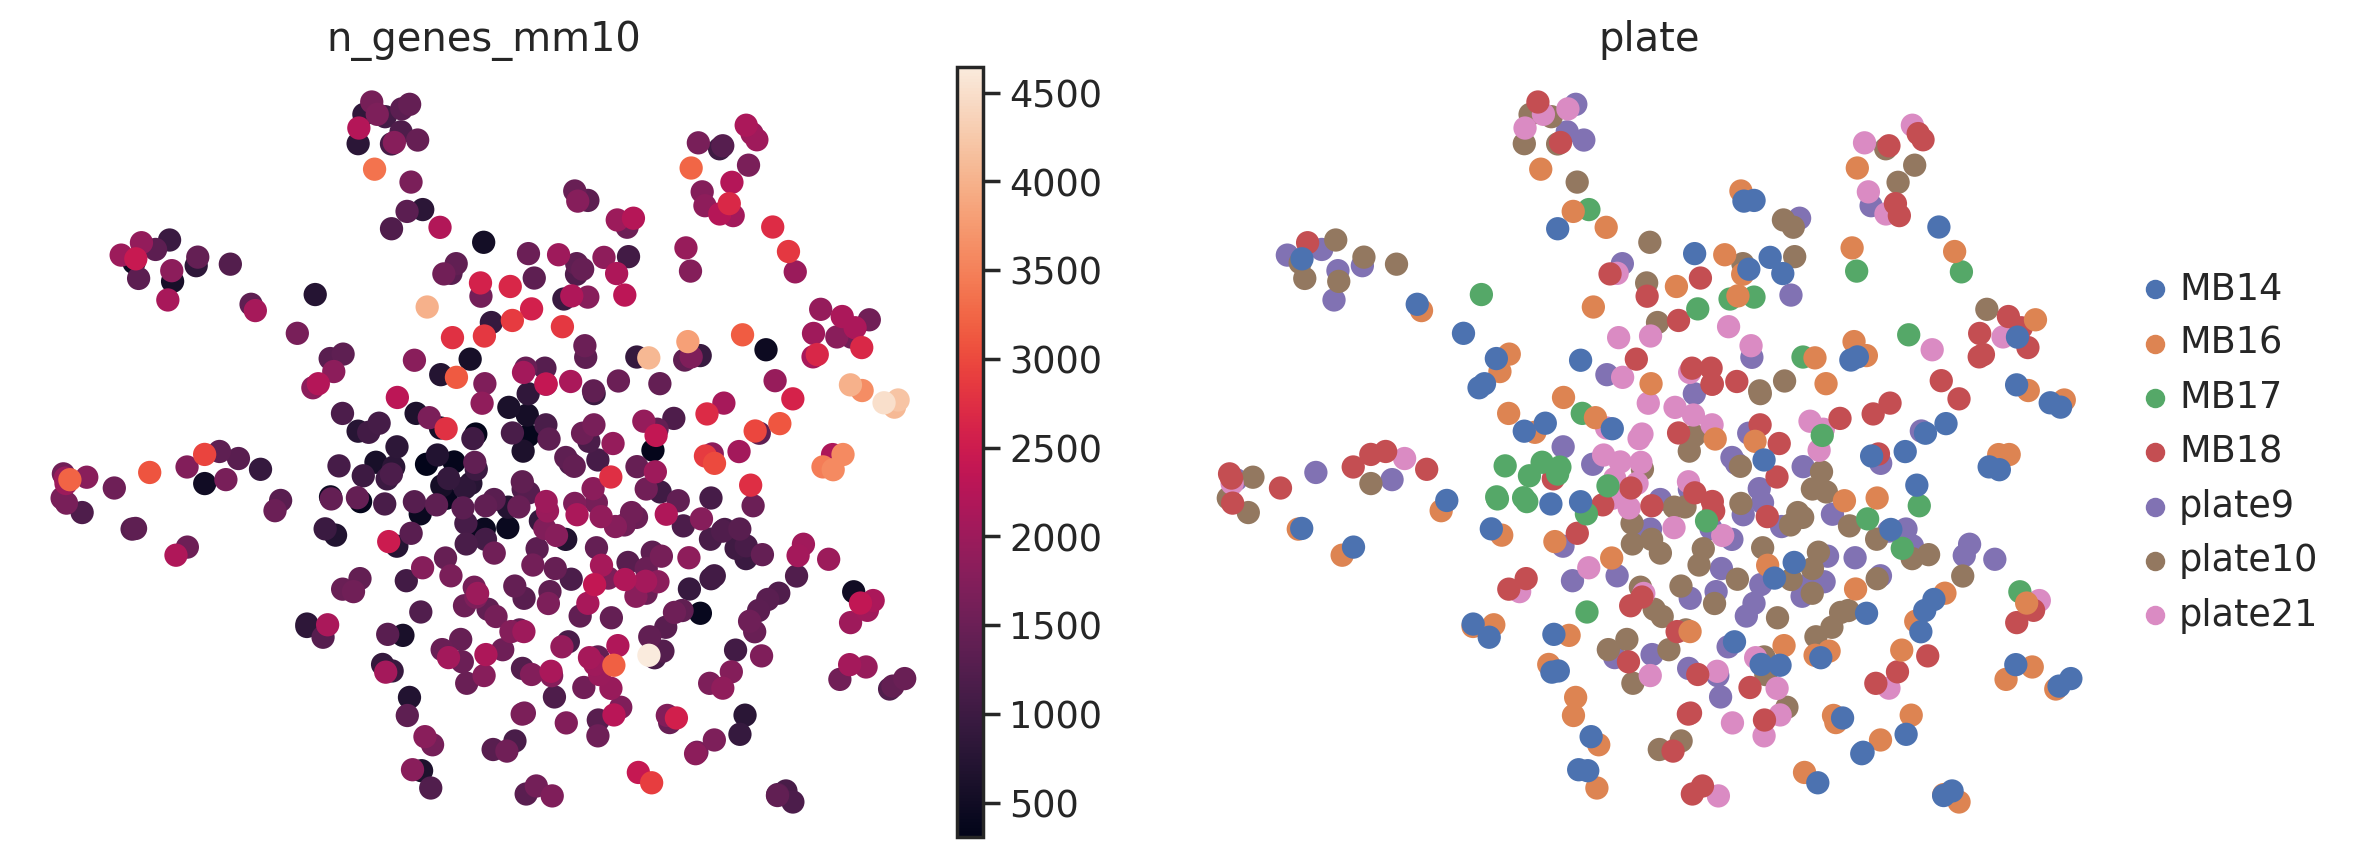

In [33]:
sc.pp.neighbors(ad, n_neighbors=10, n_pcs=30)
sc.tl.umap(ad)
sc.pl.umap(ad, color=['n_genes_mm10', 'plate'])

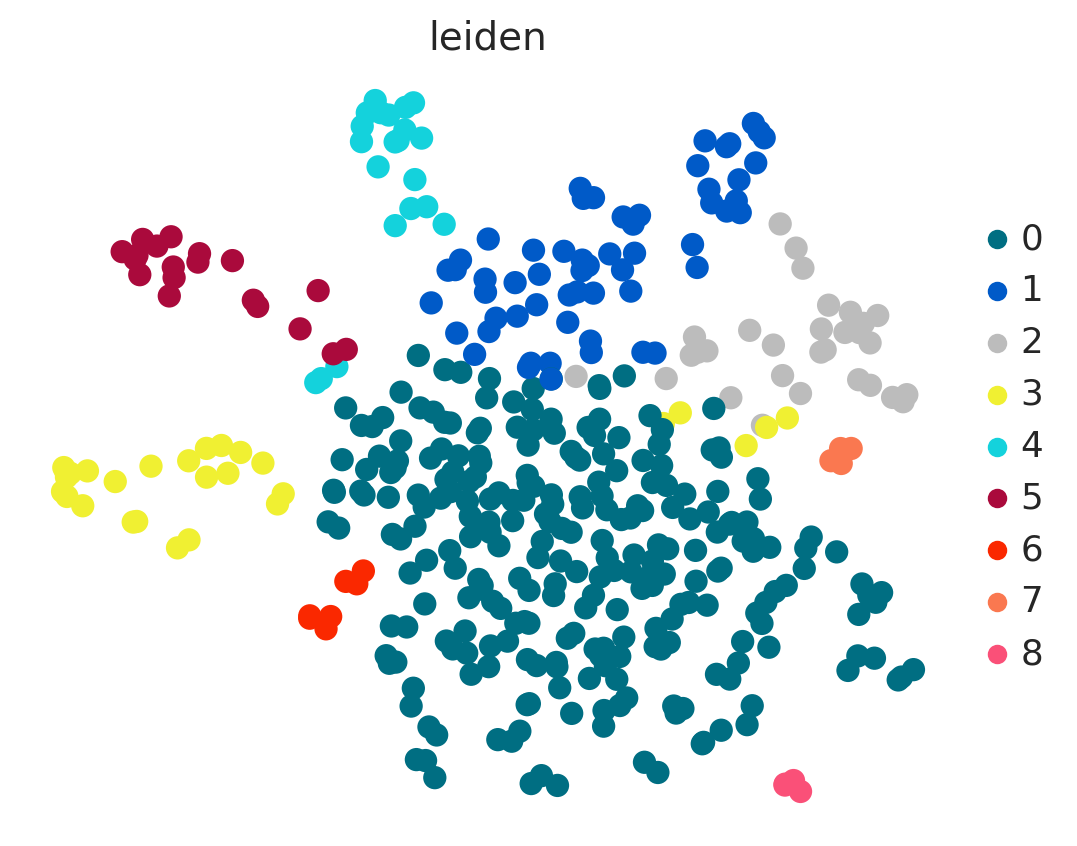

In [67]:
sc.tl.leiden(ad, resolution=0.5)
sc.pl.umap(ad, color=['leiden'], palette=ania_palette[1:], frameon=False,
           save='_SS2_leiden')

In [54]:
sc.tl.rank_genes_groups(ad, 'leiden', method='t-test')
marker_genes = pd.DataFrame(ad.uns['rank_genes_groups']['names']).head(5)
marker_dict = marker_genes.to_dict(orient='list')
marker_genes

/home/jupyter/.local/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:421: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]


0       1      2         3        4       5        6        7       8
0    Cdr1  Nckap5  Dclk1   Slc24a2     Flt1  Plxdc2     Aak1     Hpca   Rabif
1  Kcnip4  Ptprz1  Meis2     Plcl1    Sgms1   Csf1r    Fgf14     Cct2  Snap47
2  Rbfox1   Npas3  Kcnb2    Nkain2  Rundc3b  Cx3cr1     Cdr1  Fam174b   Ptprt
3   Car10   Luzp2  Kcnh7  Prickle2    Igf1r  Laptm5  Txndc16     Vwa7   Foxo3
4   Astn2   Mdga2  Tenm4     Edil3    Ptprm   Tmcc3    Lsamp   Zfp524   Rims1

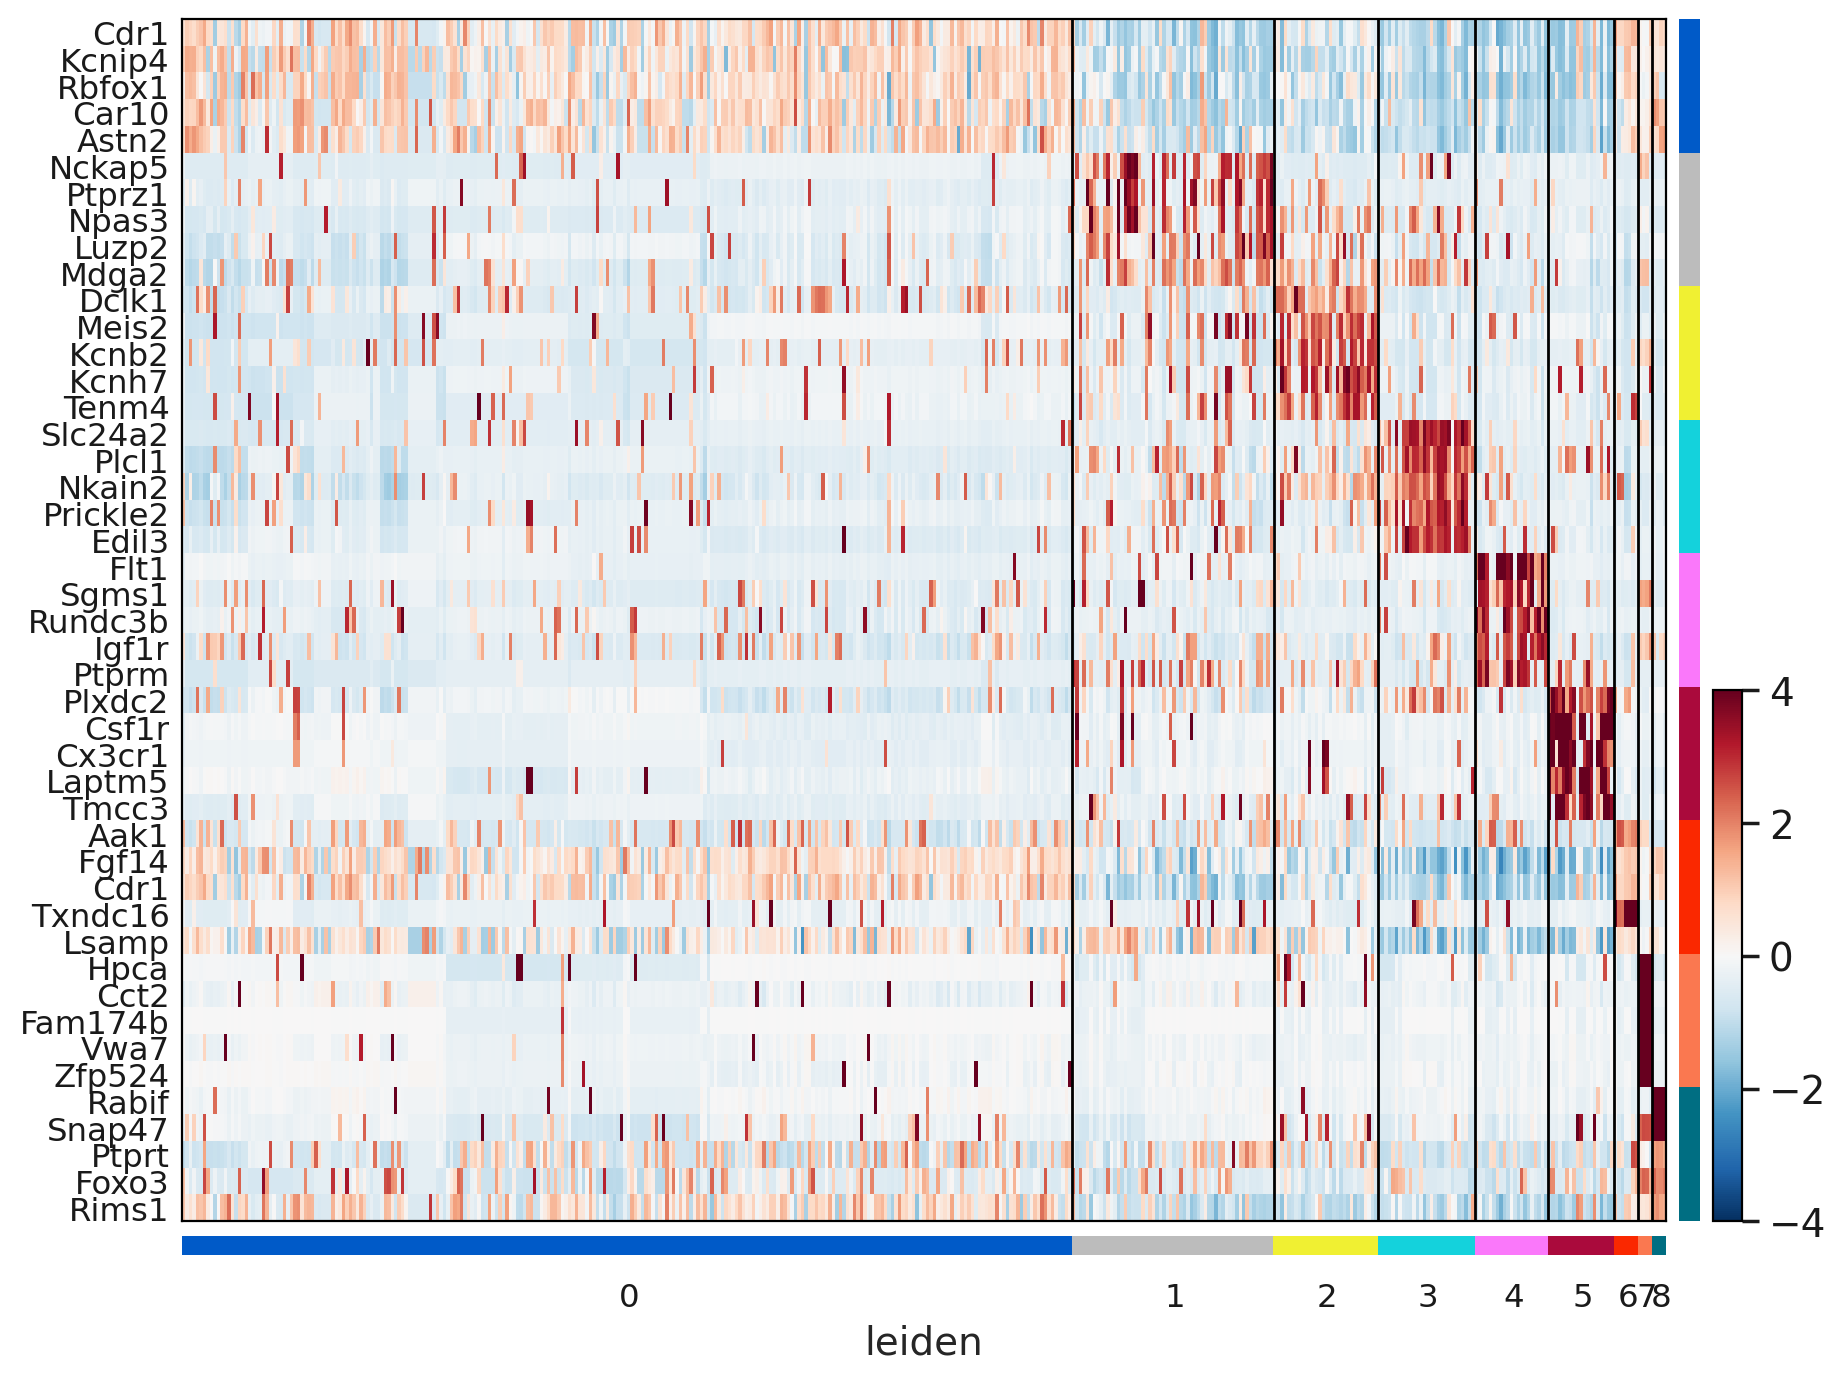

In [55]:
sc.pl.heatmap(ad, marker_dict, groupby='leiden', cmap='RdBu_r', 
              layer='scaled', vmax=4, vmin=-4, swap_axes=True, 
              show_gene_labels=True,
#               palette=ania_palette[1:],
              save='_leiden_marker_genes')

In [38]:
# merge clusters
leid_map = {'0':'0',
           '1':'1',
           '2':'2',
           '3':'3',
           '4':'4',
           '5':'5',
           '6':'0',
           '7':'0',
           '8':'0'}
ad.obs['leiden2'] = ad.obs['leiden'].map(leid_map)

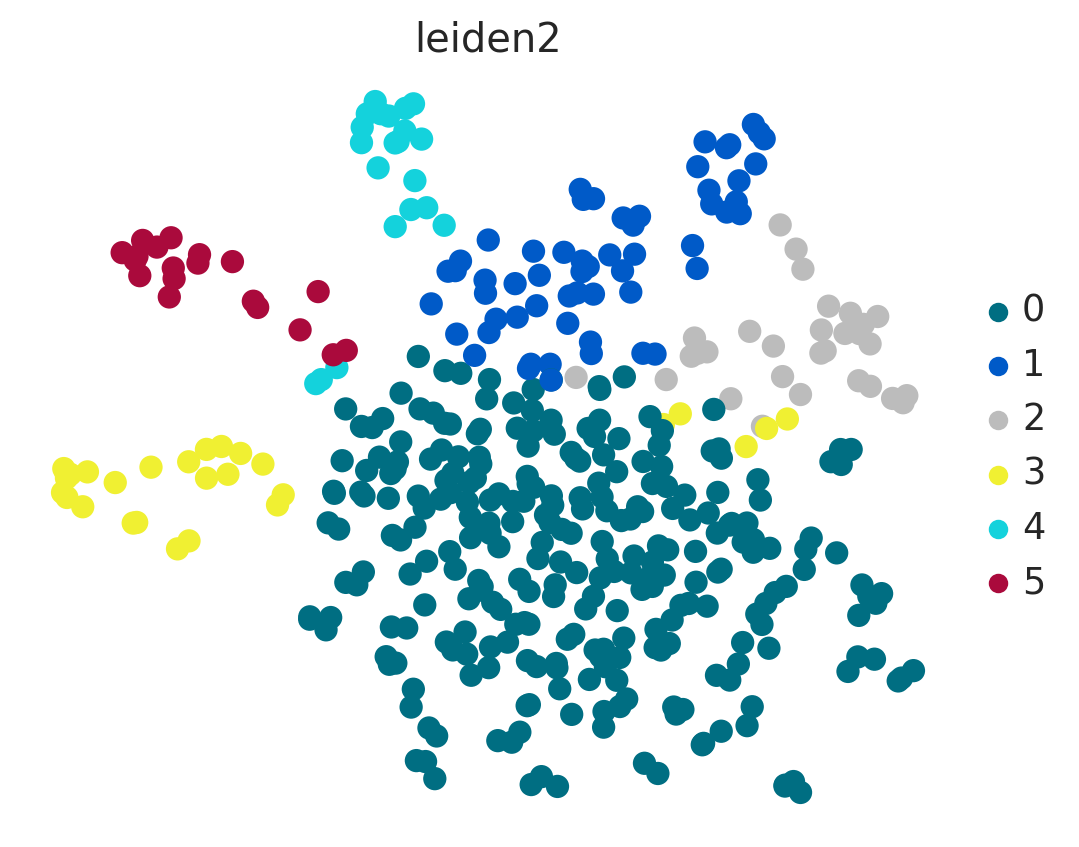

In [48]:
sc.tl.leiden(ad, resolution=0.5)
sc.pl.umap(ad, color=['leiden2'], 
           palette=ania_palette[1:], frameon=False,
           save='_SS2_leiden2')

In [68]:
sc.tl.rank_genes_groups(ad, 'leiden2', method='t-test')
marker_genes = pd.DataFrame(ad.uns['rank_genes_groups']['names']).head(10)
marker_dict = marker_genes.to_dict(orient='list')
marker_genes

/home/jupyter/.local/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:421: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]


0       1       2         3        4        5
0    Cdr1  Nckap5   Dclk1   Slc24a2     Flt1   Plxdc2
1  Kcnip4  Ptprz1   Meis2     Plcl1    Sgms1    Csf1r
2   Astn2   Npas3   Kcnb2    Nkain2  Rundc3b   Cx3cr1
3  Rbfox1   Luzp2   Kcnh7  Prickle2    Igf1r   Laptm5
4   Car10   Mdga2   Tenm4     Edil3    Ptprm    Tmcc3
5   Fgf14  Adgrl3   Gria1      Plp1    Itm2a  Epb41l2
6   Caln1   Xylt1  Camk2a        Qk    Plcb1     C1qb
7   Rims1    Gpc5   Ppm1e     Elmo1  Rapgef2     Cst3
8   Camk4    Zeb1  Kcnma1    Tmeff2    Ly6c1     Nav2
9  Pde10a  Frmd4a  Grin2b      Mobp   Atp10a     Hexb

In [69]:
# annotate
leid_to_CT = {'0':'Excitatory neurons',
             '1':'Astrocytes',
             '2':'Inhibitory neurons',
             '3':'Oligodendrocytes',
             '4':'Endothelial',
             '5':'Microglial'}
ad.obs['annotation'] = ad.obs['leiden2'].map(leid_to_CT)

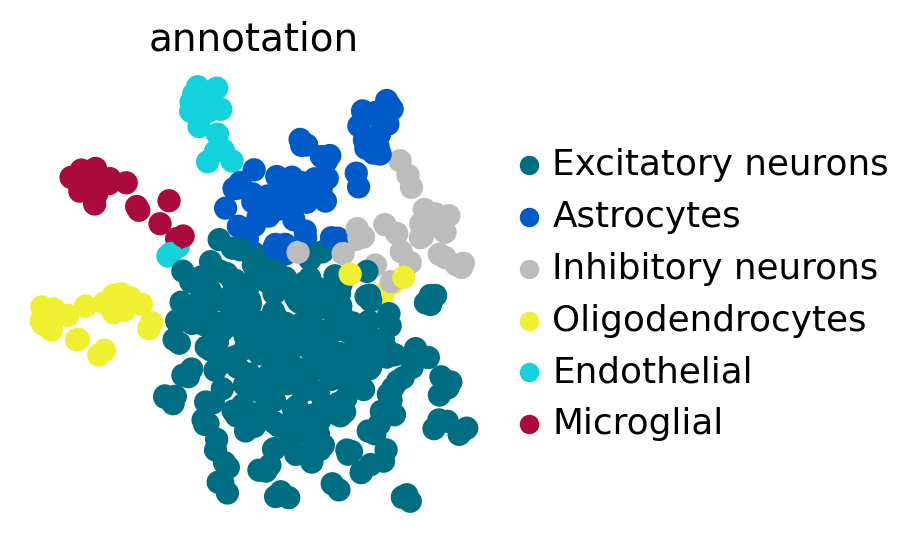

In [85]:
sc.set_figure_params(figsize=(3,3), dpi=100, frameon=False)
sc.tl.leiden(ad, resolution=0.5)
sc.pl.umap(ad, color=['annotation'], palette=ania_palette[1:], frameon=False,
           save='_SS2_annotated')

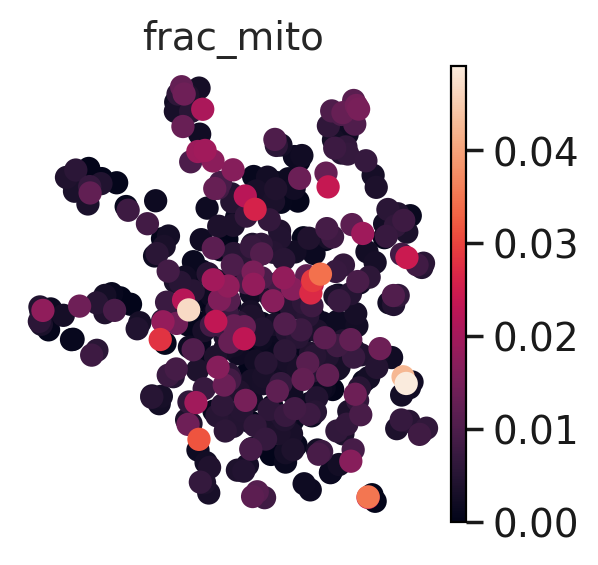

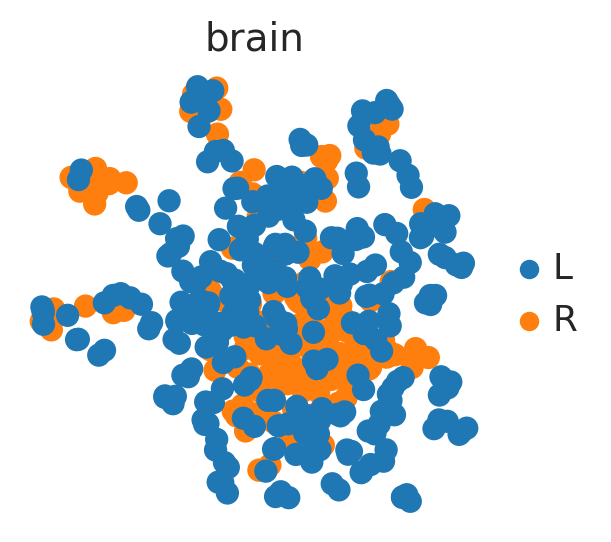

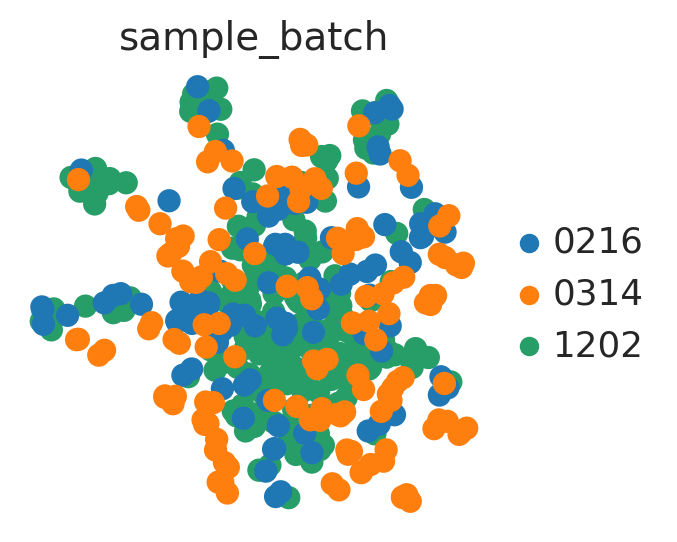

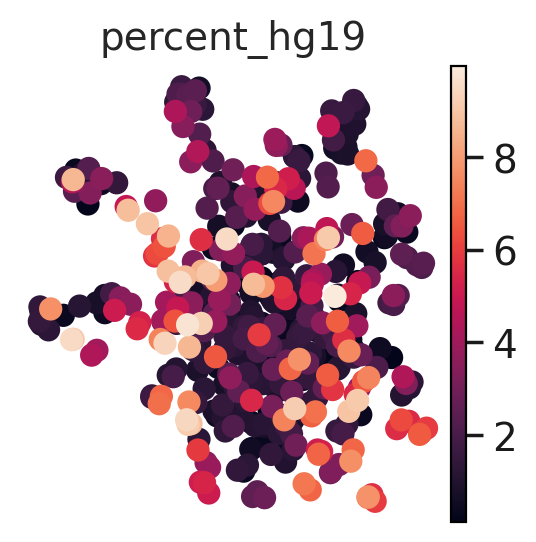

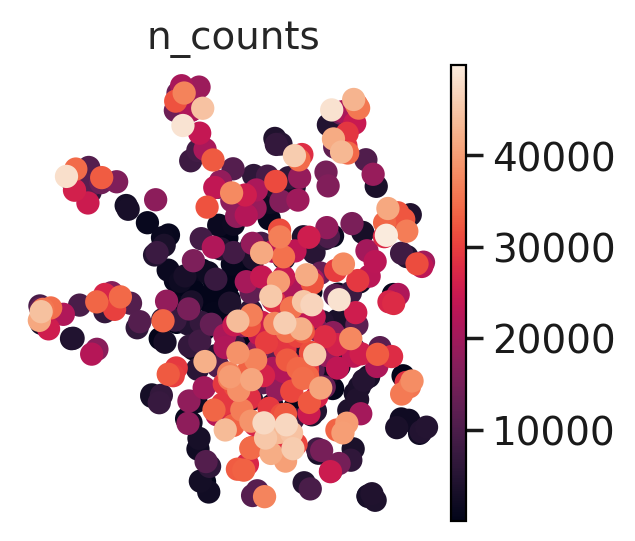

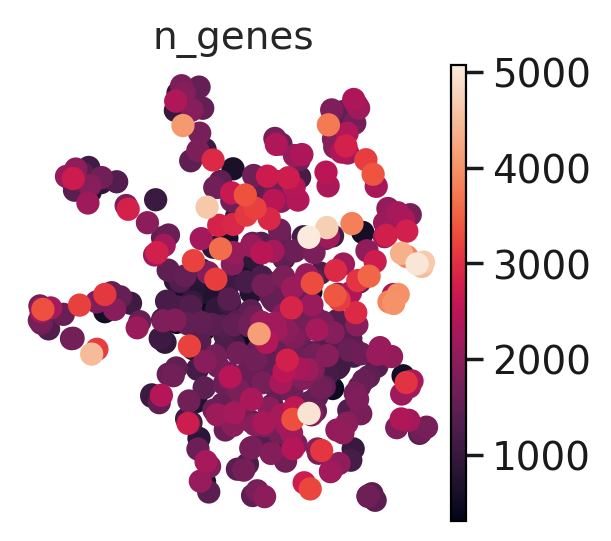

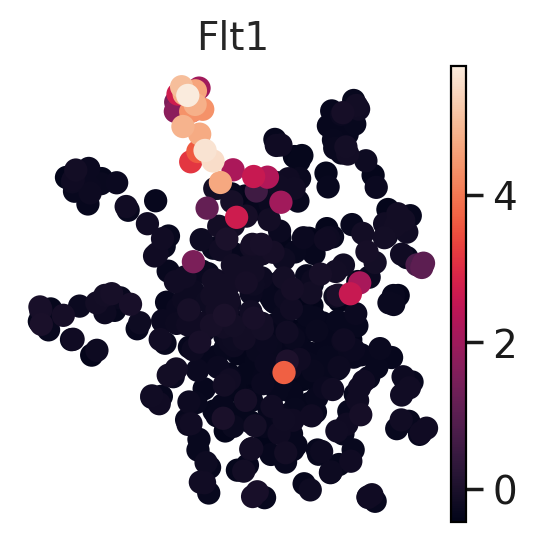

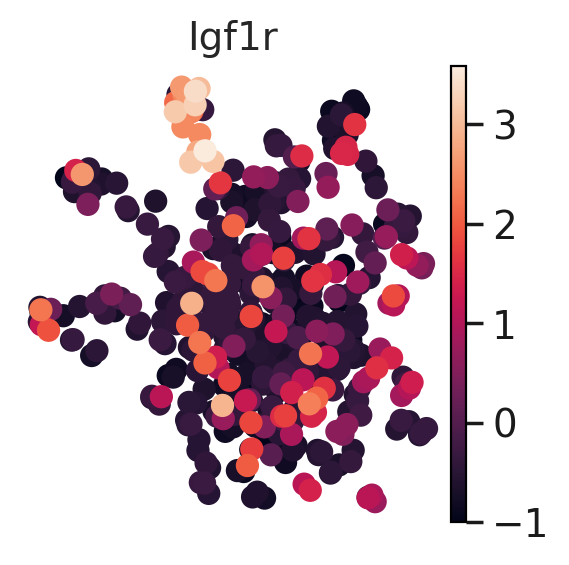

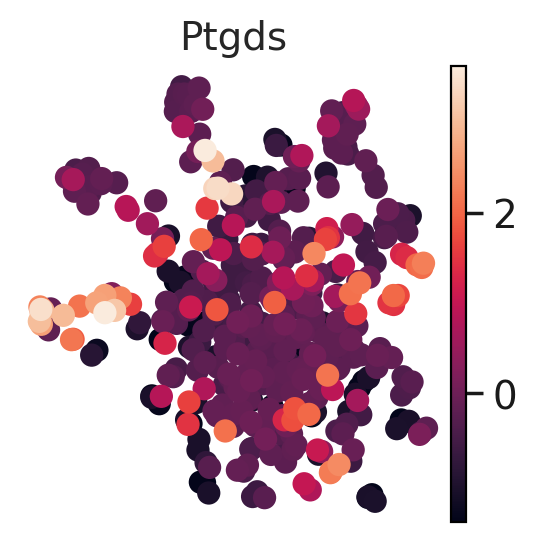

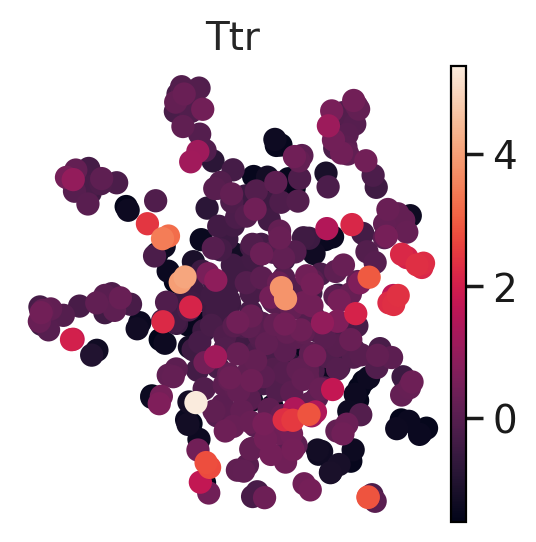

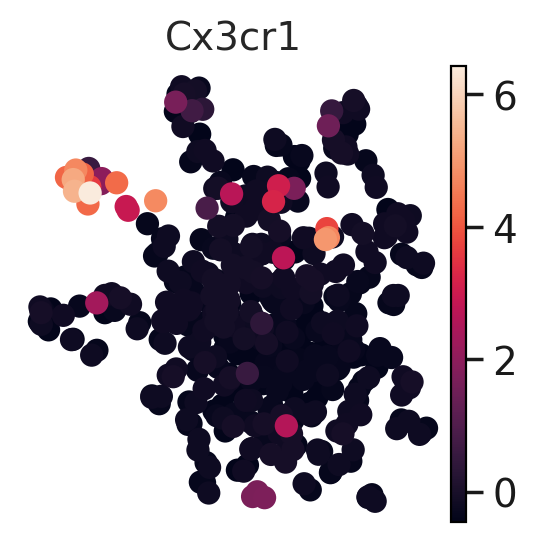

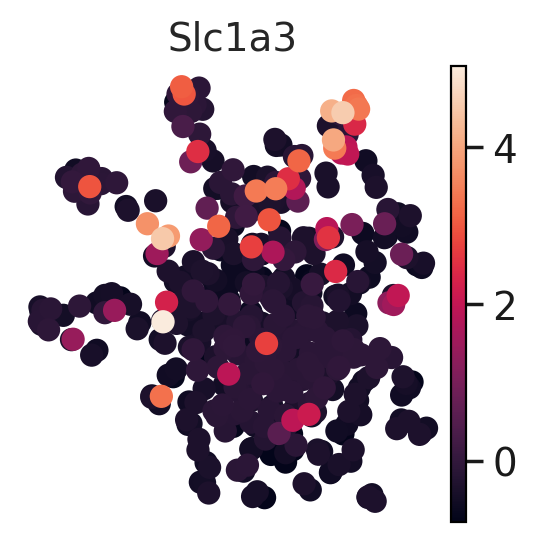

In [71]:
feats = ['frac_mito','brain', 'sample_batch', 'percent_hg19', 'n_counts', 'n_genes',
         'Flt1','Igf1r','Ptgds','Ttr','Cx3cr1','Slc1a3']
for feat in feats: 
    sc.pl.umap(ad, color=feat, frameon=False, save='_%s' %feat)

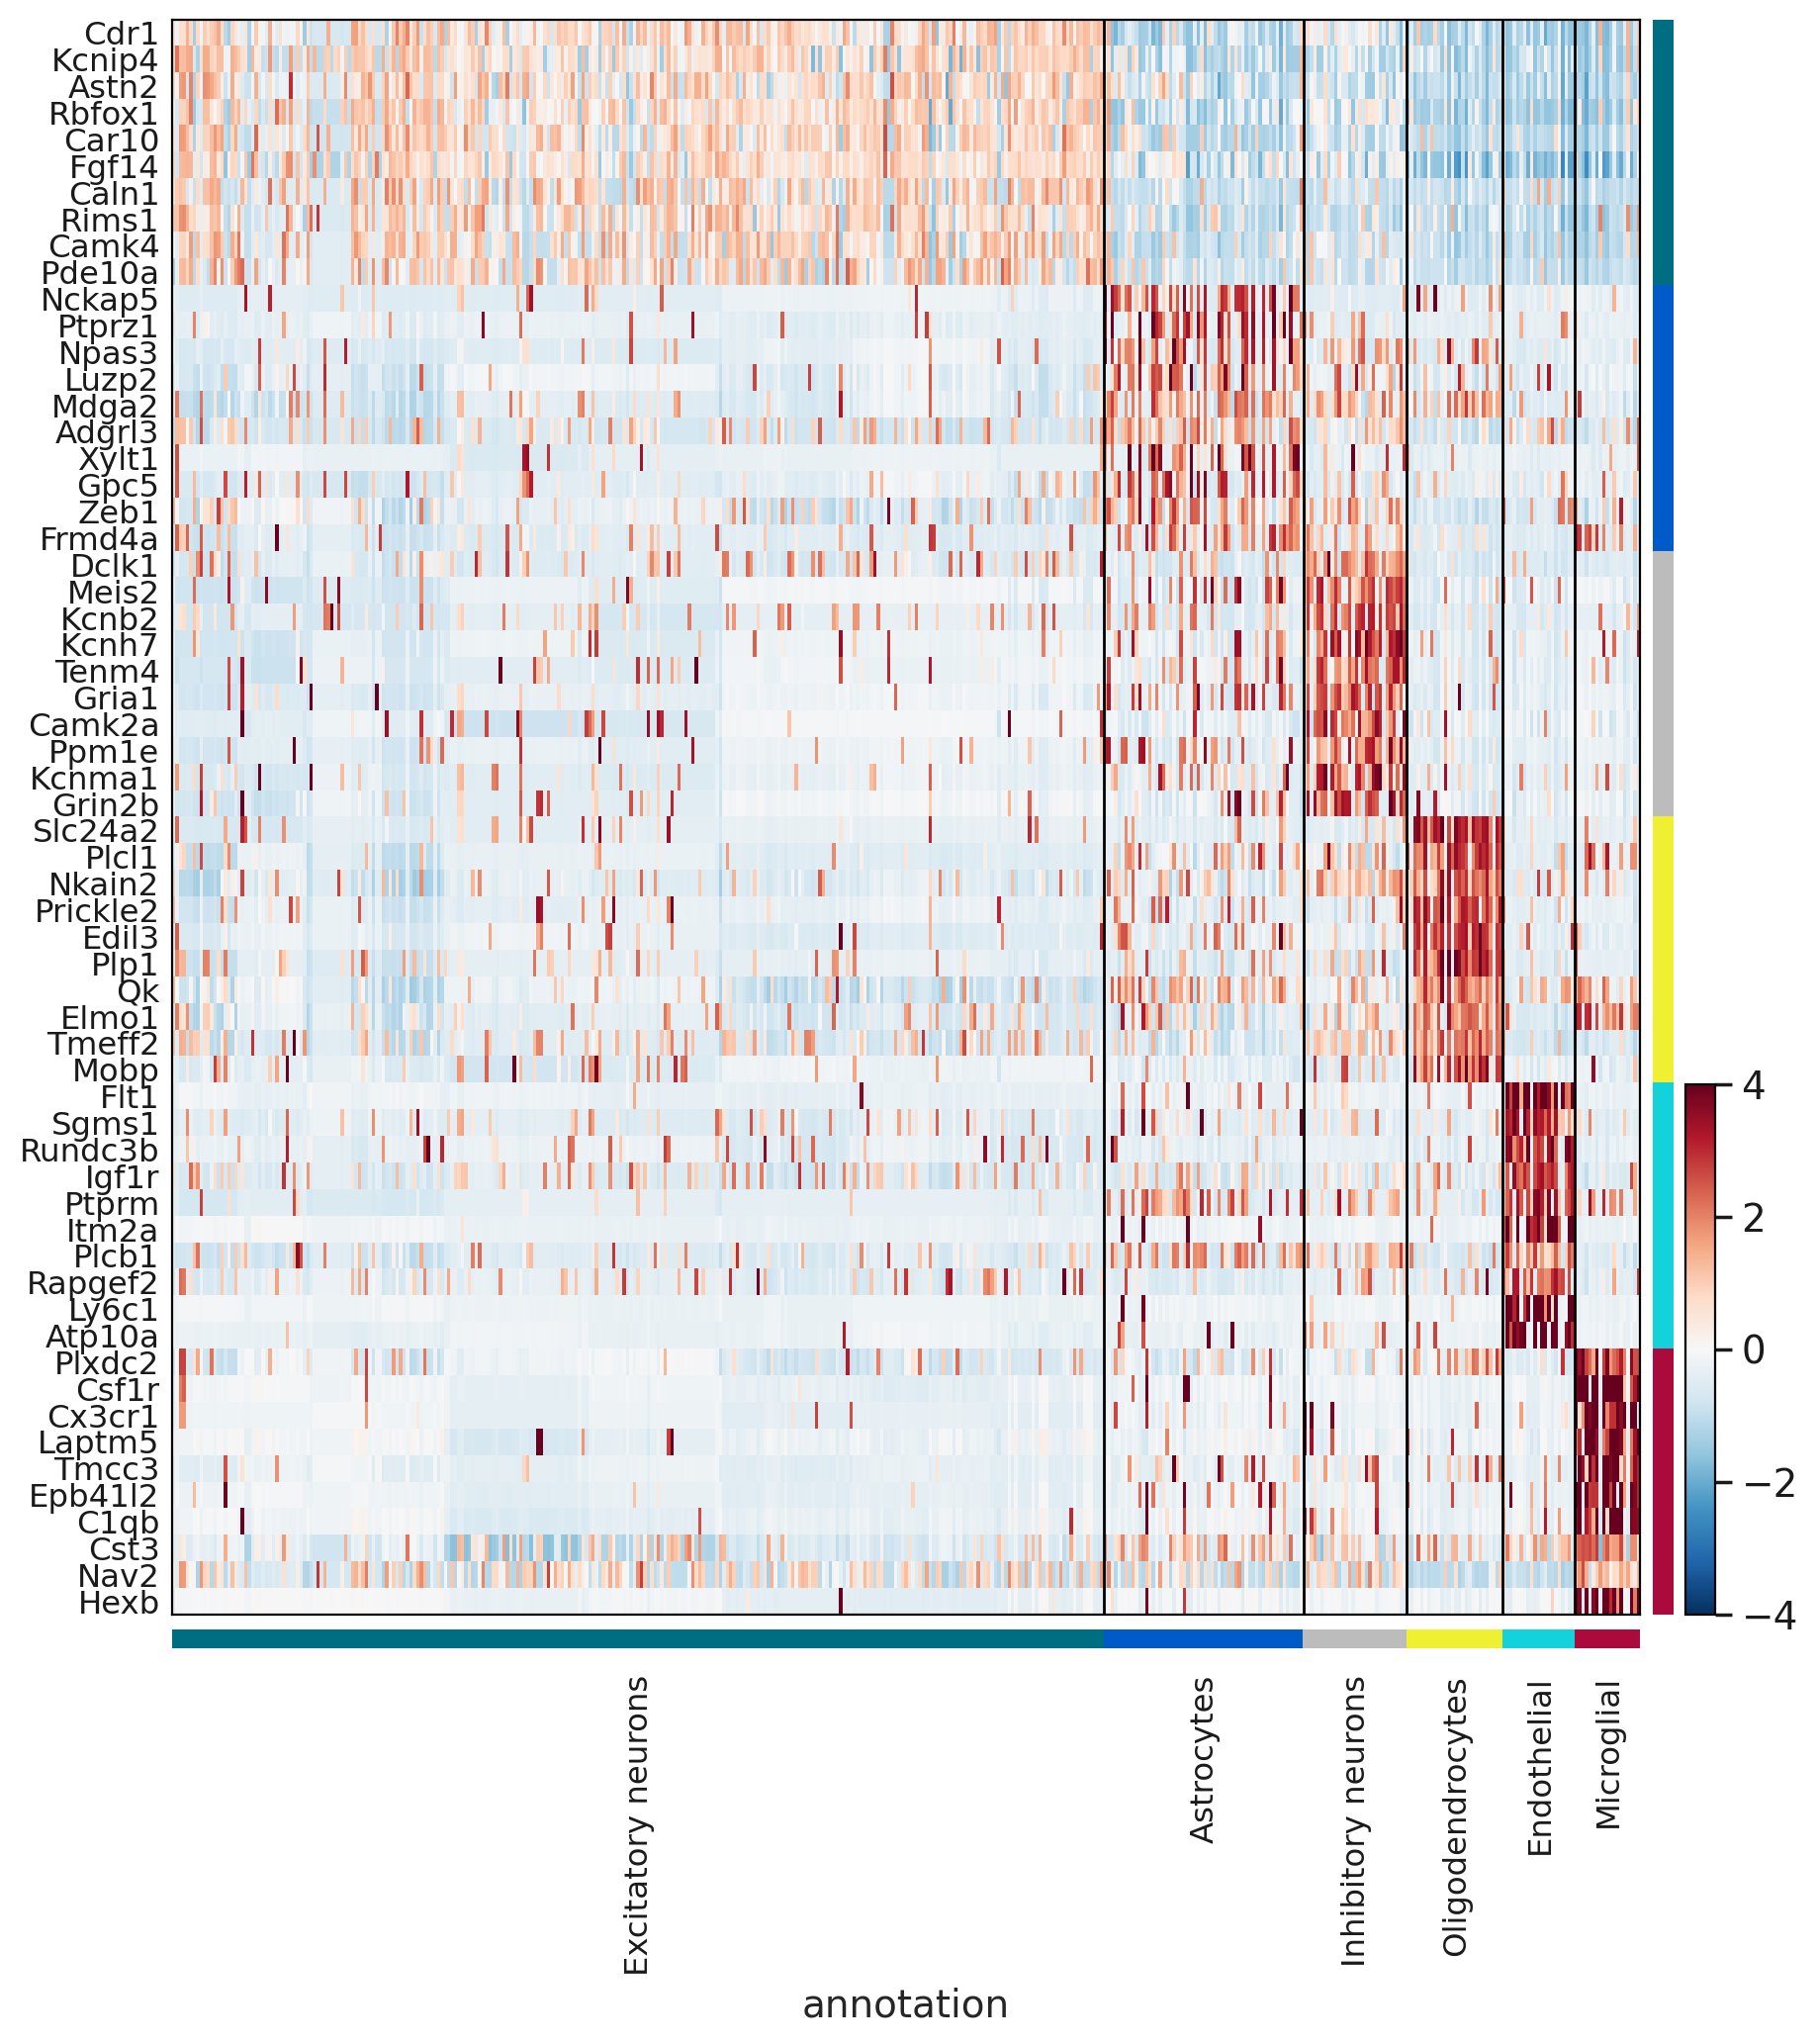

In [72]:
sc.pl.heatmap(ad, marker_dict, groupby='annotation', cmap='RdBu_r', 
              layer='scaled', vmax=4, vmin=-4, swap_axes=True, 
              show_gene_labels=True,
              save='_annotated_marker_genes')

### save clustered data

In [74]:
# save
ad.write('FFPE/analysis/mouse_brain/SS2_mouse_cortex_clustered_v2.h5ad')

## Clustermap of marker gene expression

In [2]:
ad = sc.read('FFPE/analysis/mouse_brain/SS2_mouse_cortex_clustered_v2.h5ad')
ad.uns['log1p']["base"] = None

In [3]:
sc.tl.rank_genes_groups(ad, 'leiden2', method='t-test')
marker_genes = pd.DataFrame(ad.uns['rank_genes_groups']['names']).head(10)
marker_dict = marker_genes.to_dict(orient='list')
marker_genes

/home/jupyter/.local/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:421: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]


0       1       2         3        4        5
0    Cdr1  Nckap5   Dclk1   Slc24a2     Flt1   Plxdc2
1  Kcnip4  Ptprz1   Meis2     Plcl1    Sgms1    Csf1r
2   Astn2   Npas3   Kcnb2    Nkain2  Rundc3b   Cx3cr1
3  Rbfox1   Luzp2   Kcnh7  Prickle2    Igf1r   Laptm5
4   Car10   Mdga2   Tenm4     Edil3    Ptprm    Tmcc3
5   Fgf14  Adgrl3   Gria1      Plp1    Itm2a  Epb41l2
6   Caln1   Xylt1  Camk2a        Qk    Plcb1     C1qb
7   Rims1    Gpc5   Ppm1e     Elmo1  Rapgef2     Cst3
8   Camk4    Zeb1  Kcnma1    Tmeff2    Ly6c1     Nav2
9  Pde10a  Frmd4a  Grin2b      Mobp   Atp10a     Hexb

In [4]:
marker_genes.to_csv('%s/Annotation_FFPE_brain_SS2.csv' %(sc.settings.figdir))

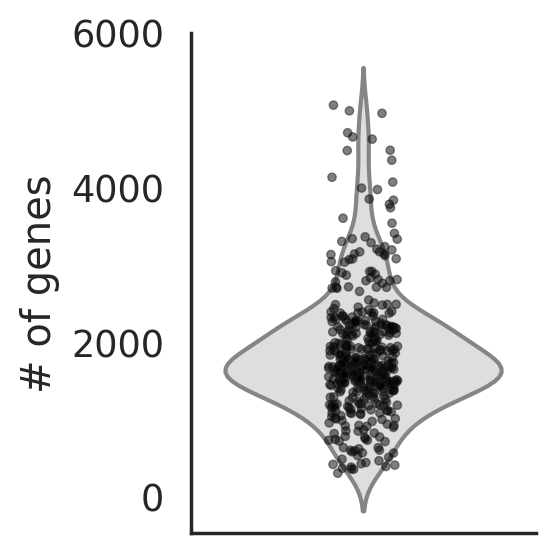

In [58]:
fig, ax = plt.subplots(figsize=(3,3))
sns.set(font_scale=1.2)
sns.set_style("white")
g = sns.stripplot(y='n_genes',
                  data=ad.obs, 
                    jitter=True,
                    marker='o',
                    palette=['#000000'],
                    size=3,
                    alpha=0.5,
                    edgecolor='k',
                    linewidth=0.5,
                    )
g = sns.violinplot(y='n_genes',
                  data=ad.obs, 
                   inner=None,
                   color='#DEDEDE')
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.yticks(np.arange(0,7000,2000))
plt.xticks(rotation=90)
ax.set_ylabel('# of genes')
plt.tight_layout()
g.get_figure().savefig(bbox_inches='tight',
                       fname='%s/violin_stripplot_SS2_mouse_brain_ngenes.pdf' %(sc.settings.figdir))

In [6]:
ad = sc.pp.subsample(ad, fraction=1, copy=True)

In [7]:
sc.tl.rank_genes_groups(ad, 'leiden2', method='t-test')
marker_genes = pd.DataFrame(ad.uns['rank_genes_groups']['names']).head(10)
marker_dict = marker_genes.to_dict(orient='list')
marker_genes

# annotate
leid_to_CT = {'0':'Excitatory neurons',
             '1':'Astrocytes',
             '2':'Inhibitory neurons',
             '3':'Oligodendrocytes',
             '4':'Endothelial',
             '5':'Microglial'}
ad.obs['annotation'] = ad.obs['leiden2'].map(leid_to_CT)

/home/jupyter/.local/lib/python3.7/site-packages/scanpy/tools/_rank_genes_groups.py:421: RuntimeWarning: invalid value encountered in log2
  foldchanges[global_indices]


In [13]:
cell_type_colors = ['#006E82', # exci
                     '#005AC8', # astro
                     '#bcbcbc', #inhib
                     '#F0F032', #oligo
                        '#AA0A3C', #microglia
                        '#14D2DC']

In [9]:
from typing import Optional, Union, Mapping
from typing import Sequence, Collection

var_names, var_group_labels, var_group_positions = sc.pl._anndata._check_var_names_type(marker_dict, [], [])

_VarNames = Union[str, Sequence[str]]
categories, obs_tidy = sc.pl._anndata._prepare_dataframe(
        ad,
        var_names,
        'annotation',
        use_raw=None,
        log=False,
        num_categories=7,
        gene_symbols=None,
        layer='scaled',
    )

In [10]:
index = obs_tidy.index.argsort()
obs_tidy = obs_tidy.sort_index()

In [11]:
cluster_idx = pd.DataFrame(obs_tidy.index.map({'Excitatory neurons':0,
                                   'Astrocytes':1,
                                   'Inhibitory neurons':2,
                                   'Oligodendrocytes':3,
                                   'Microglial':4,
                                   'Endothelial':5}).values.to_list())

plate_idx = pd.DataFrame(ad.obs.iloc[index]['Plate'].map({'Plate1':0,
                                   'Plate2':1,
                                   'Plate3':2,
                                   'Plate4':3,
                                   'Plate5':4,
                                   'Plate6':5,
                                    'Plate7':6}).values.to_list())

<Figure size 600x600 with 0 Axes>

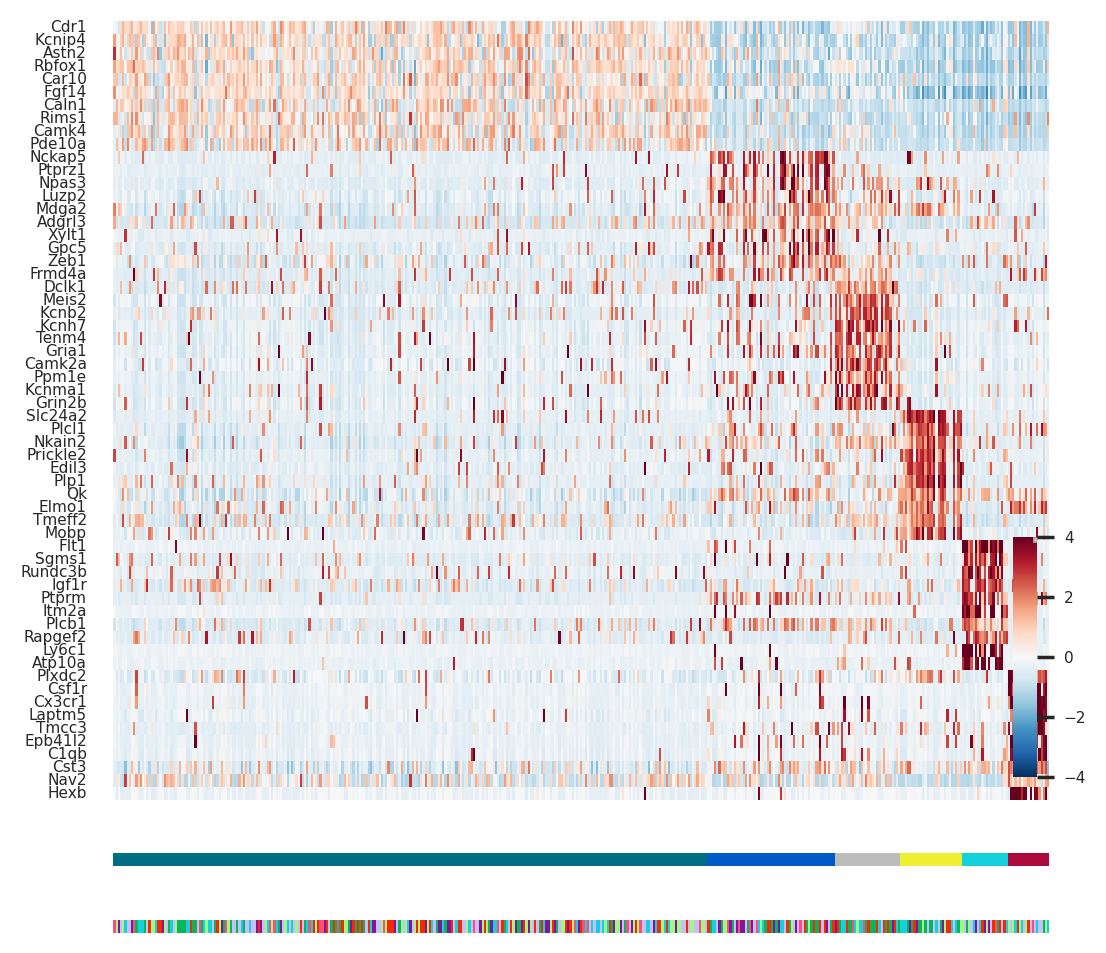

In [14]:
sns.set(font_scale = 0.5)
plt.figure(figsize=(6,6))

import seaborn as sns
# sns.reset_orig()
fig, (ax1, ax2, ax3) = plt.subplots(3, 1, sharex=True, figsize=(6,6), 
                               gridspec_kw={'height_ratios': [3, 0.05, 0.05]})

# subplot 1
cax = fig.add_axes([.93, .28, .02, .2])
sns.set(font_scale = 0.02)
ax_h = sns.heatmap(obs_tidy.T,
                 cmap='RdBu_r',
                   vmin=-4, vmax=4, center=0,
                yticklabels=obs_tidy.columns,
                xticklabels=obs_tidy.index,
                 ax=ax1,
                cbar_ax=cax)
ax_h.set(xlabel=None)

# subplot 2
sns.heatmap(cluster_idx.T,
           cmap=cell_type_colors,
           yticklabels=[], xticklabels=[],
           ax=ax2, 
            vmin=0, vmax=5,
            cbar=False)

# subplot 3
sns.heatmap(plate_idx.T,
           cmap=ania_palette[5:],
           yticklabels=[], xticklabels=[],
           ax=ax3, 
            vmin=0, vmax=8,
            cbar=False)

cbar_kws=dict(ticks=[])

plt.legend('')
plt.savefig('%s/heatmap_SS2_FFPE_brain_plate_with_colorbars.pdf' %sc.settings.figdir)

sns.reset_orig()